In [1]:
import pandas as pd
import numpy as np

import source.utility as ut
import source.transf_univ as df_p
import source.report as rp
from source.validate import random_split, yearly_split

from sklearn.model_selection import KFold
from scipy.interpolate import UnivariateSpline

from sklearn.linear_model import Lasso, Ridge, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, ExtraTreesClassifier, ExtraTreesRegressor
from xgboost import XGBRegressor, XGBClassifier
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option('max_columns', 300)

kfolds = KFold(n_splits=5, shuffle=True, random_state=345)

In [2]:
df = pd.read_csv('data/processed_women/training_data.csv')

df.head()

,Season,DayNum,Team1,Team2,target,target_points,T1_Loc,T2_Loc,ID,T1_Ast,T1_Ast_advantage,T1_Ast_diff,T1_Away,T1_Blk,T1_Blk_advantage,T1_Blk_diff,T1_DR,T1_DR_advantage,T1_DR_diff,T1_DR_opportunity,T1_DR_opportunity_advantage,T1_DR_opportunity_diff,T1_FGA,T1_FGA2,T1_FGA2_advantage,T1_FGA2_diff,T1_FGA3,T1_FGA3_advantage,T1_FGA3_diff,T1_FGA_advantage,T1_FGA_diff,T1_FGM,T1_FGM2,T1_FGM2_advantage,T1_FGM2_diff,T1_FGM3,T1_FGM3_advantage,T1_FGM3_diff,T1_FGM_advantage,T1_FGM_diff,T1_FGM_no_ast,T1_FGM_no_ast_advantage,T1_FGM_no_ast_diff,T1_FTA,T1_FTA_advantage,T1_FTA_diff,T1_FTM,T1_FTM_advantage,T1_FTM_diff,T1_N_wins,T1_OR,T1_OR_advantage,T1_OR_diff,T1_OR_opportunity,T1_OR_opportunity_advantage,T1_OR_opportunity_diff,T1_OT_win,T1_PF,T1_PF_advantage,T1_PF_diff,T1_Score,T1_Score_advantage,T1_Score_diff,T1_Stl,T1_Stl_advantage,T1_Stl_diff,T1_TO,T1_TO_advantage,T1_TO_diff,T1_TO_perposs,T1_TO_perposs_advantage,T1_TO_perposs_diff,T1_Tot_Reb,T1_Tot_Reb_advantage,T1_Tot_Reb_diff,T1_True_shooting_perc_advantage,T1_True_shooting_perc_diff,T1_def_rating,T1_def_rating_advantage,T1_def_rating_diff,T1_impact,T1_impact_advantage,T1_impact_diff,T1_off_rating,T1_off_rating_advantage,T1_off_rating_diff,T1_opp_FGA,T1_opp_FTA,T1_opp_possessions,T1_opp_score,T1_opp_shtg_opportunity,T1_possessions,T1_possessions_advantage,T1_possessions_diff,T1_shtg_opportunity,T1_shtg_opportunity_advantage,T1_shtg_opportunity_diff,T1_FGM_perc,T1_FGM2_perc,T1_FGM3_perc,T1_FT_perc,T1_FGM_no_ast_perc,T1_True_shooting_perc,T1_Opp_True_shooting_perc,T1_OT_win_perc,T1_Seed,T2_Ast,T2_Ast_advantage,T2_Ast_diff,T2_Away,T2_Blk,T2_Blk_advantage,T2_Blk_diff,T2_DR,T2_DR_advantage,T2_DR_diff,T2_DR_opportunity,T2_DR_opportunity_advantage,T2_DR_opportunity_diff,T2_FGA,T2_FGA2,T2_FGA2_advantage,T2_FGA2_diff,T2_FGA3,T2_FGA3_advantage,T2_FGA3_diff,T2_FGA_advantage,T2_FGA_diff,T2_FGM,T2_FGM2,T2_FGM2_advantage,T2_FGM2_diff,T2_FGM3,T2_FGM3_advantage,T2_FGM3_diff,T2_FGM_advantage,T2_FGM_diff,T2_FGM_no_ast,T2_FGM_no_ast_advantage,T2_FGM_no_ast_diff,T2_FTA,T2_FTA_advantage,T2_FTA_diff,T2_FTM,T2_FTM_advantage,T2_FTM_diff,T2_N_wins,T2_OR,T2_OR_advantage,T2_OR_diff,...,T2_Score_diff,T2_Stl,T2_Stl_advantage,T2_Stl_diff,T2_TO,T2_TO_advantage,T2_TO_diff,T2_TO_perposs,T2_TO_perposs_advantage,T2_TO_perposs_diff,T2_Tot_Reb,T2_Tot_Reb_advantage,T2_Tot_Reb_diff,T2_True_shooting_perc_advantage,T2_True_shooting_perc_diff,T2_def_rating,T2_def_rating_advantage,T2_def_rating_diff,T2_impact,T2_impact_advantage,T2_impact_diff,T2_off_rating,T2_off_rating_advantage,T2_off_rating_diff,T2_opp_FGA,T2_opp_FTA,T2_opp_possessions,T2_opp_score,T2_opp_shtg_opportunity,T2_possessions,T2_possessions_advantage,T2_possessions_diff,T2_shtg_opportunity,T2_shtg_opportunity_advantage,T2_shtg_opportunity_diff,T2_FGM_perc,T2_FGM2_perc,T2_FGM3_perc,T2_FT_perc,T2_FGM_no_ast_perc,T2_True_shooting_perc,T2_Opp_True_shooting_perc,T2_OT_win_perc,T2_Seed,delta_Loc,delta_Ast,delta_Ast_advantage,delta_Ast_diff,delta_Away,delta_Blk,delta_Blk_advantage,delta_Blk_diff,delta_DR,delta_DR_advantage,delta_DR_diff,delta_DR_opportunity,delta_DR_opportunity_advantage,delta_DR_opportunity_diff,delta_FGA,delta_FGA2,delta_FGA2_advantage,delta_FGA2_diff,delta_FGA3,delta_FGA3_advantage,delta_FGA3_diff,delta_FGA_advantage,delta_FGA_diff,delta_FGM,delta_FGM2,delta_FGM2_advantage,delta_FGM2_diff,delta_FGM3,delta_FGM3_advantage,delta_FGM3_diff,delta_FGM_advantage,delta_FGM_diff,delta_FGM_no_ast,delta_FGM_no_ast_advantage,delta_FGM_no_ast_diff,delta_FTA,delta_FTA_advantage,delta_FTA_diff,delta_FTM,delta_FTM_advantage,delta_FTM_diff,delta_N_wins,delta_OR,delta_OR_advantage,delta_OR_diff,delta_OR_opportunity,delta_OR_opportunity_advantage,delta_OR_opportunity_diff,delta_OT_win,delta_PF,delta_PF_advantage,delta_PF_diff,delta_Score,delta_Score_advantage,delta_Score_diff,delta_Stl,delta_Stl_advantage,delta_Stl_diff,delta_TO,delta_TO_advantage,delta_TO_diff,delta_TO_perposs,delta_TO_perposs_advantage,delta_TO_perposs_diff,delta_Tot_Reb,delta_Tot_Reb_advantage,delta_Tot_Re

In [3]:
standard = ['Season', 'target', 'target_points', 'ID', 'Team1', 'Team2', 'T1_Loc', 'T2_Loc', 'delta_Loc', 'DayNum']

l2w = [col for col in df if 'L2W' in col and col not in standard]
tot = [col for col in df if 'L2W' not in col and col not in standard]
l2w_deltas = [col for col in df if 'L2W' in col and col not in standard and 'delta' in col]
tot_deltas = [col for col in df if 'L2W' not in col and col not in standard and 'delta' in col]

In [4]:
to_drop = (['T1_Score_advantage', 'T2_Score_advantage', 'delta_Score_advantage'] +
           [col for col in df if 'FGM_diff' in col or 'FGM_advantage' in col] + 
           [col for col in df if 'FGA_diff' in col or 'FTM_diff' in col or 'FTM_advantage' in col] + 
           [col for col in df if 'OR_diff' in col or 'OR_advantage' in col] + 
           [col for col in df if 'DR_diff' in col or 'DR_advantage' in col] + 
           [col for col in df if 'Stl_diff' in col or 'Stl_advantage' in col] + 
           [col for col in df if 'Blk_diff' in col or 'Blk_advantage' in col] + 
           [col for col in df if '_PF' in col] + 
           [col for col in df if 'FGM_no_ast_diff' in col or 'FGM_no_ast_advantage' in col] + 
           [col for col in df if 'opp_FGA' in col] + 
           [col for col in df if 'FGM_no_ast_perc' in col])

In [5]:
special_selection = ([col for col in df if 'Ast' in col and 'diff' not in col and 'advantage' not in col] + 
                     [col for col in df if 'Away' in col] + [col for col in df if 'OT_win_perc' in col] +
                     [col for col in df if 'Blk' in col and 'diff' not in col and 'advantage' not in col] + 
                     [col for col in df if 'DR' in col and 'diff' not in col and 'advantage' not in col] + 
                     [col for col in df if 'OR' in col and 'diff' not in col and 'advantage' not in col] + 
                     [col for col in df if 'FGA' in col and ('diff' in col or 'advantage' in col)] + 
                     [col for col in df if 'FGM' in col and 'diff' not in col and 'advantage' not in col] + 
                     [col for col in df if 'Score' in col and 'diff' not in col and 'advantage' not in col] + 
                     [col for col in df if 'Stl' in col and 'diff' not in col and 'advantage' not in col] + 
                     [col for col in df if 'TO_perposs' in col and 'diff' not in col and 'advantage' not in col] + 
                     [col for col in df if 'Tot_Reb' in col] + [col for col in df if 'possessions' in col] + 
                     [col for col in df if 'True_shooting_perc' in col] + 
                     [col for col in df if 'top_team' in col or 'upset' in col] + 
                     [col for col in df if 'off_rating' in col and 'diff' not in col and 'advantage' not in col] + 
                     [col for col in df if 'def_rating' in col and 'diff' not in col and 'advantage' not in col] + 
                     [col for col in df if 'impact' in col and 'diff' not in col and 'advantage' not in col] + 
                     [col for col in df if 'Seed' in col])

# Lasso

-9.759080018832126
{'feat_sel__k': 50, 'lasso__alpha': 0.01, 'scl__method': 'robust'}
-9.427045834694933
{'feat_sel__k': 50, 'lasso__alpha': 0.11, 'scl__method': 'robust'}
-9.386697456567026
{'feat_sel__k': 100, 'lasso__alpha': 0.11, 'scl__method': 'robust'}
-9.324510775225958
{'feat_sel__k': 'all', 'lasso__alpha': 0.11, 'scl__method': 'standard'}
-9.775523962328188
{'feat_sel__k': 100, 'lasso__alpha': 0.11, 'scl__method': 'robust'}
2015


MAE train: 			 9.8539
MAE test: 			 8.6009
RMSE train: 			 12.4392
RMSE test: 			 11.1475
Accuracy train: 		 0.7919
Accuracy test: 			 0.8571
AUC ROC train: 			 0.7919
AUC ROC test: 			 0.8571
Logloss train: 			 0.4249
Logloss test: 			 0.4061
Unsure train: 			 9.79%
Unsure test: 			 9.52%


________________________________________


2016


MAE train: 			 9.4866
MAE test: 			 11.0296
RMSE train: 			 12.1055
RMSE test: 			 13.6202
Accuracy train: 		 0.8175
Accuracy test: 			 0.6984
AUC ROC train: 			 0.8175
AUC ROC test: 			 0.6984
Logloss train: 			 

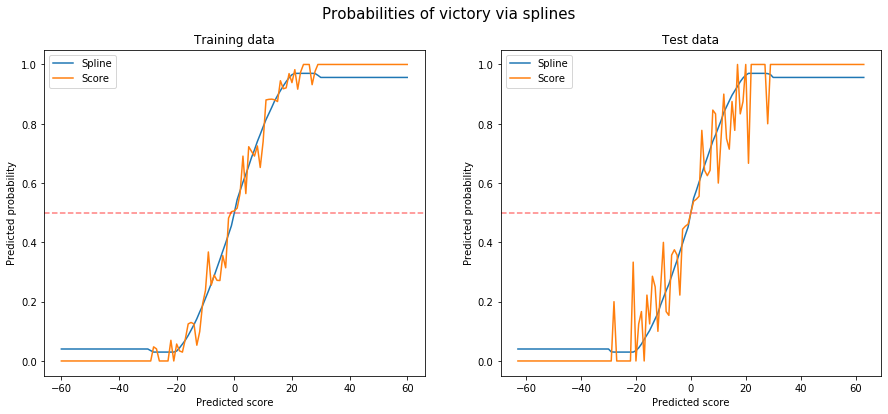

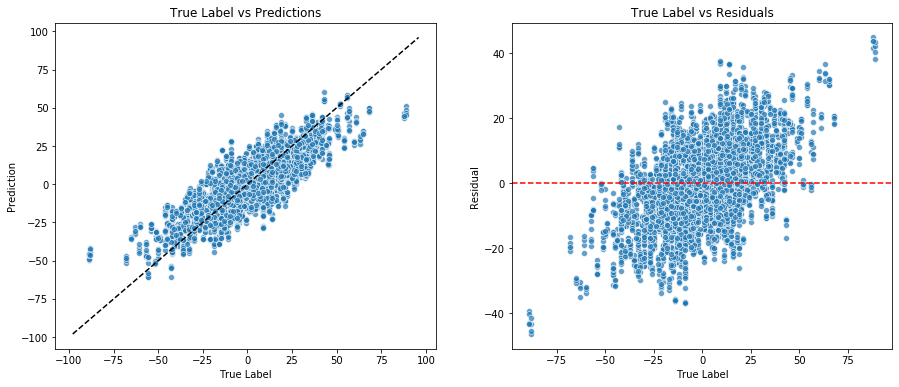

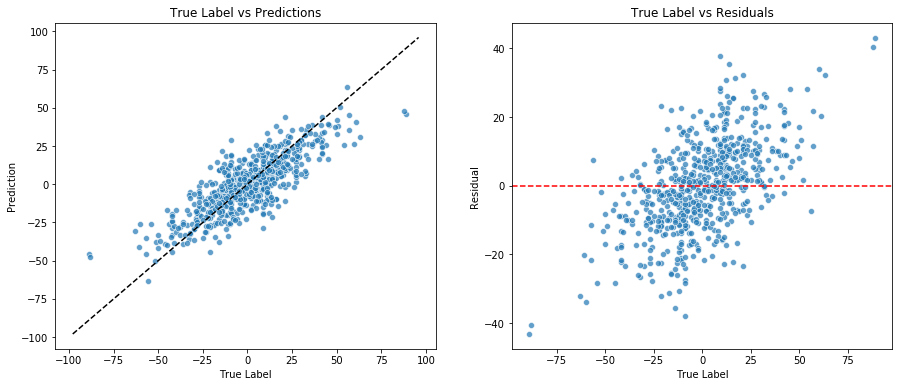

MAE train: 			 9.5994
MAE test: 			 10.2868
RMSE train: 			 12.1779
RMSE test: 			 13.1556
Accuracy train: 		 0.7993
Accuracy test: 			 0.7968
AUC ROC train: 			 0.7993
AUC ROC test: 			 0.7968
Logloss train: 			 0.4183
Logloss test: 			 0.453
Unsure train: 			 9.1%
Unsure test: 			 8.89%


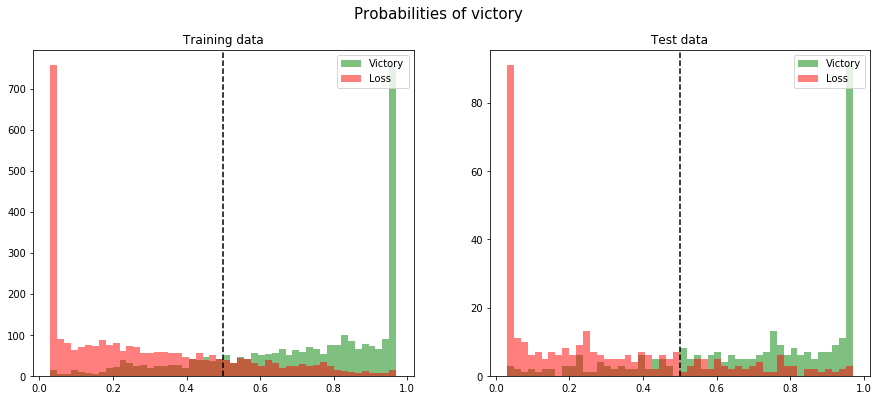

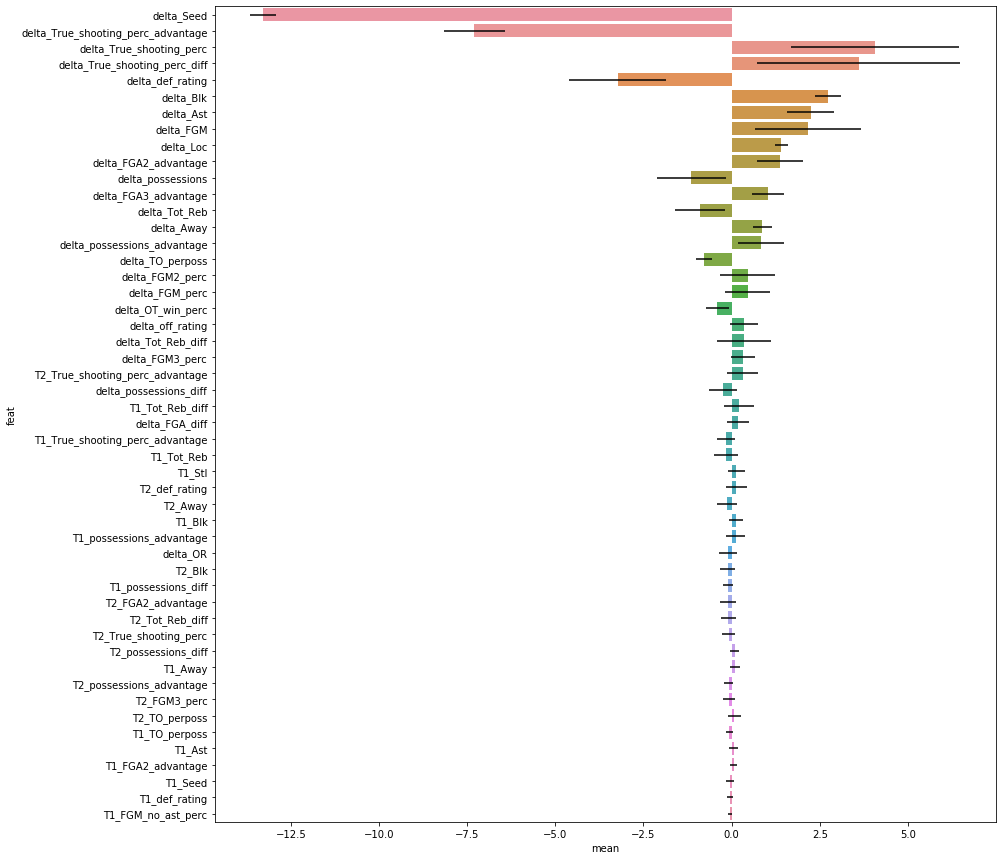

In [6]:
pipe = Pipeline([('scl', df_p.df_scaler()), 
                 ('feat_sel', df_p.selector(mode='reg'))] + [('lasso', Lasso(alpha=0.1, max_iter=2000))])

df_train = df[standard + special_selection]#.drop(['T1_Loc', 'T2_Loc', 'delta_Loc'] + to_drop, axis=1)

grid = {'lasso__alpha': np.arange(0.01, 2, 0.1), 
        'scl__method': ['standard', 'robust'], 
        'feat_sel__k': [5, 10 , 20, 50, 100, 'all']}

fitted_las, oof_pred_las, test_pred_las, imp_coef_las, train_las, y_train_las, test_las, y_test_las = yearly_split(df_train, pipe, kfolds, 'target_points', tune=True, param_grid=grid)

rp.yearly_wrapper(train_las, test_las, y_train_las, y_test_las, oof_pred_las, test_pred_las)

plt.figure(figsize=(14, 15))
sns.barplot(x="mean", y="feat", 
            data=imp_coef_las['2019'].head(50).reset_index(), 
            xerr=imp_coef_las['2019'].head(50)['std'])
plt.show()

# Ridge

-9.805395710957551
{'feat_sel__k': 50, 'ridge__alpha': 100, 'scl__method': 'standard'}
-9.484919894282736
{'feat_sel__k': 100, 'ridge__alpha': 100, 'scl__method': 'standard'}
-9.437308254109745
{'feat_sel__k': 50, 'ridge__alpha': 100, 'scl__method': 'standard'}
-9.377384362606007
{'feat_sel__k': 'all', 'ridge__alpha': 100, 'scl__method': 'standard'}
-9.806863468317488
{'feat_sel__k': 50, 'ridge__alpha': 100, 'scl__method': 'standard'}
2015


MAE train: 			 9.8426
MAE test: 			 8.0835
RMSE train: 			 12.4392
RMSE test: 			 10.7446
Accuracy train: 		 0.7972
Accuracy test: 			 0.8571
AUC ROC train: 			 0.7972
AUC ROC test: 			 0.8571
Logloss train: 			 0.4244
Logloss test: 			 0.4062
Unsure train: 			 9.35%
Unsure test: 			 11.11%


________________________________________


2016


MAE train: 			 9.501
MAE test: 			 11.3135
RMSE train: 			 12.1791
RMSE test: 			 13.8772
Accuracy train: 		 0.8131
Accuracy test: 			 0.6667
AUC ROC train: 			 0.8131
AUC ROC test: 			 0.6667
Logloss train: 		

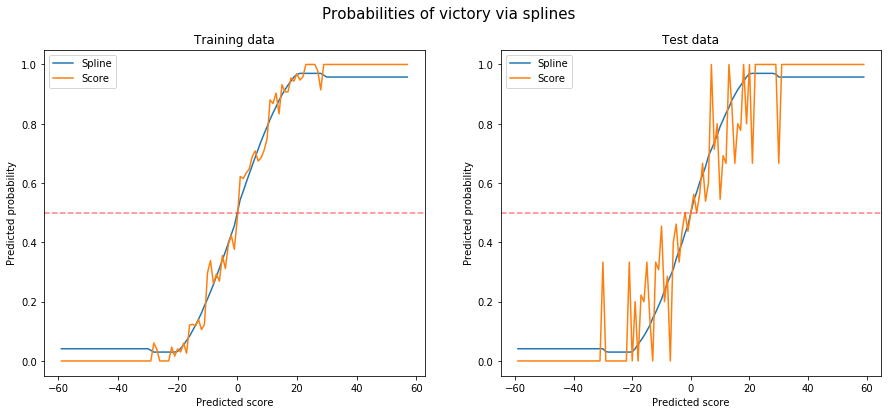

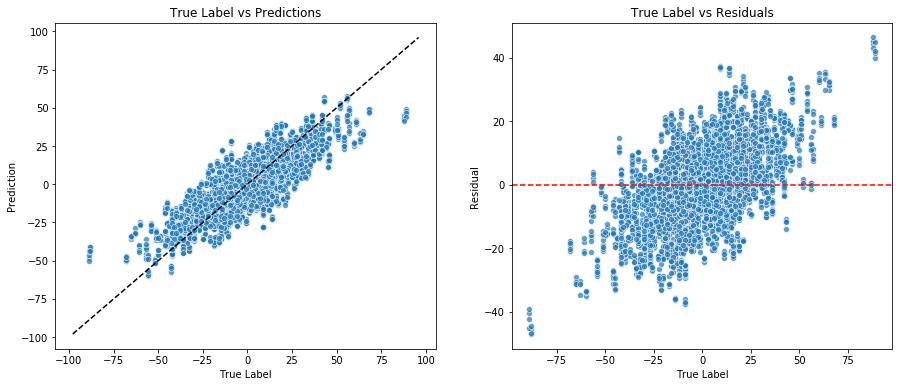

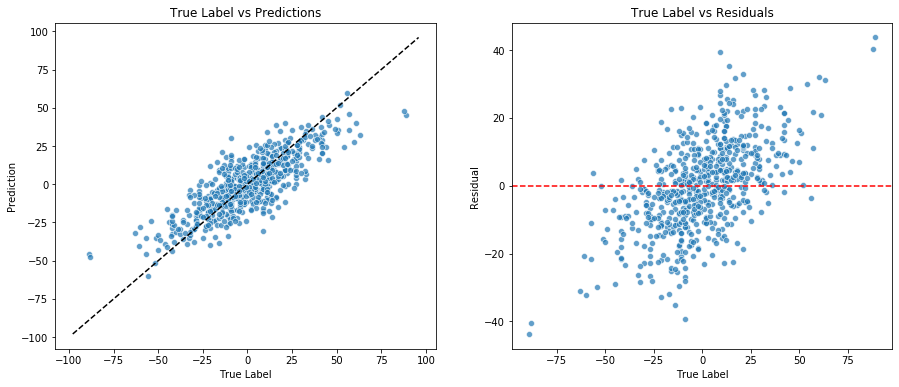

MAE train: 			 9.6054
MAE test: 			 10.2628
RMSE train: 			 12.2123
RMSE test: 			 13.148
Accuracy train: 		 0.8004
Accuracy test: 			 0.7905
AUC ROC train: 			 0.8004
AUC ROC test: 			 0.7905
Logloss train: 			 0.4201
Logloss test: 			 0.4532
Unsure train: 			 8.87%
Unsure test: 			 8.25%


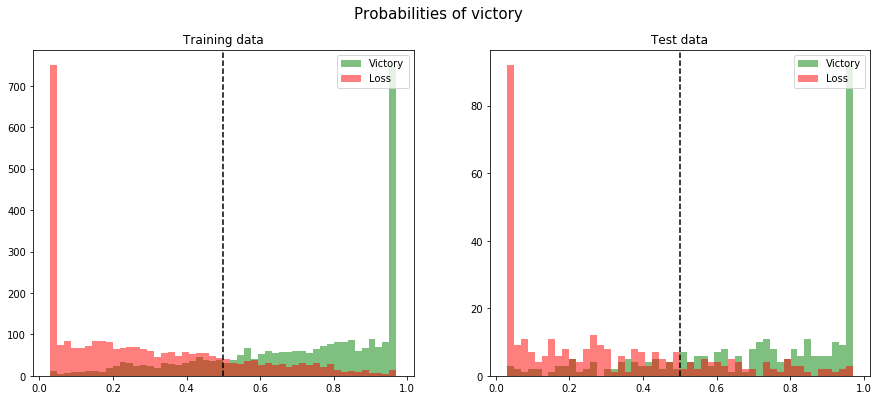

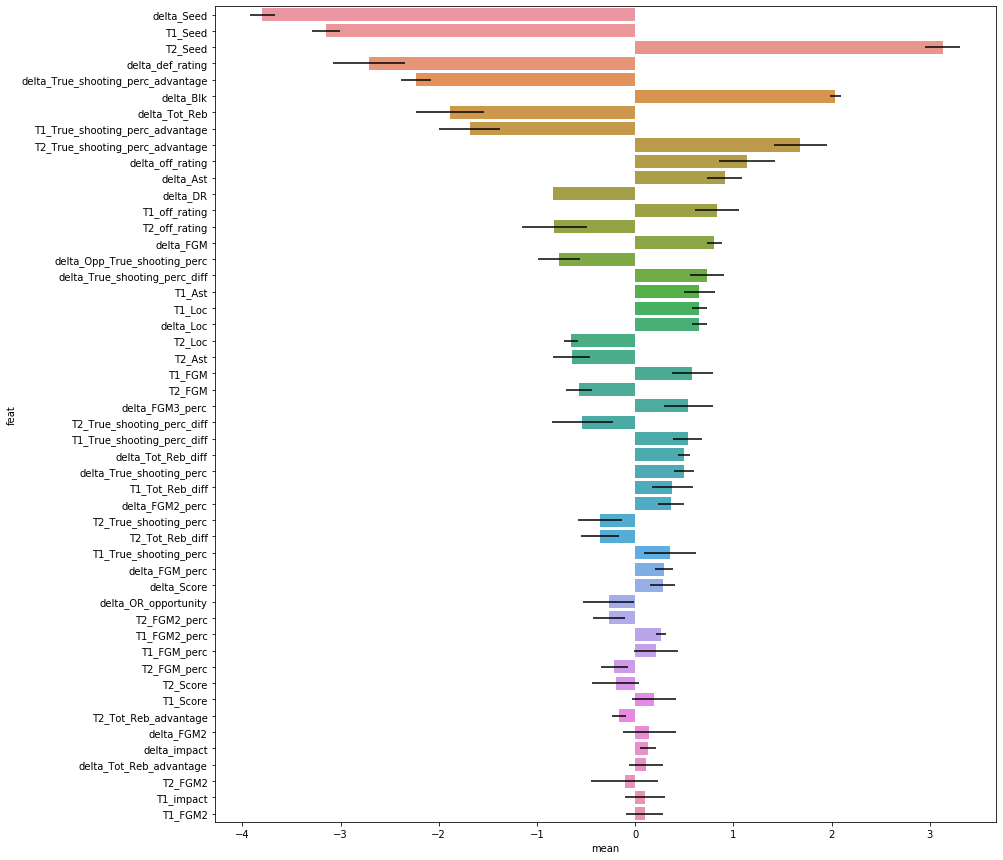

In [7]:
pipe = Pipeline([('scl', df_p.df_scaler()), 
                 ('feat_sel', df_p.selector(mode='reg'))] + [('ridge', Ridge())])

df_train = df[standard + special_selection]#.drop(['T1_Loc', 'T2_Loc', 'delta_Loc'] + to_drop, axis=1)

grid = {'ridge__alpha': np.arange(100, 300, 2), 
        'scl__method': ['standard', 'robust'], 
        'feat_sel__k': [5, 10 , 20, 50, 100, 'all']}

fitted_rid, oof_pred_rid, test_pred_rid, imp_coef_rid, train_rid, y_train_rid, test_rid, y_test_rid = yearly_split(df_train, pipe, kfolds, 'target_points', tune=True, param_grid=grid)

rp.yearly_wrapper(train_rid, test_rid, y_train_rid, y_test_rid, oof_pred_rid, test_pred_rid)

plt.figure(figsize=(14, 15))
sns.barplot(x="mean", y="feat", 
            data=imp_coef_rid['2019'].head(50).reset_index(), 
            xerr=imp_coef_rid['2019'].head(50)['std'])
plt.show()

# Logit

-0.41707649888485426
{'feat_sel__k': 50, 'logit__C': 0.155, 'scl__method': 'standard'}
-0.40244005694564444
{'feat_sel__k': 70, 'logit__C': 0.08999999999999998, 'scl__method': 'standard'}
-0.4126582029264287
{'feat_sel__k': 50, 'logit__C': 0.155, 'scl__method': 'standard'}
-0.41004023984922905
{'feat_sel__k': 'all', 'logit__C': 0.06499999999999999, 'scl__method': 'standard'}
-0.4244725653815567
{'feat_sel__k': 50, 'logit__C': 0.37499999999999994, 'scl__method': 'robust'}
2015


Accuracy train: 		 0.7813
Accuracy test: 			 0.8095
AUC ROC train: 			 0.7813
AUC ROC test: 			 0.8095
Logloss train: 			 0.4261
Logloss test: 			 0.4101
Unsure train: 			 13.0511%
Unsure test: 			 11.1111%


________________________________________


2016


Accuracy train: 		 0.8131
Accuracy test: 			 0.6667
AUC ROC train: 			 0.8131
AUC ROC test: 			 0.6667
Logloss train: 			 0.4114
Logloss test: 			 0.554
Unsure train: 			 12.0811%
Unsure test: 			 9.5238%


________________________________________


2017


A

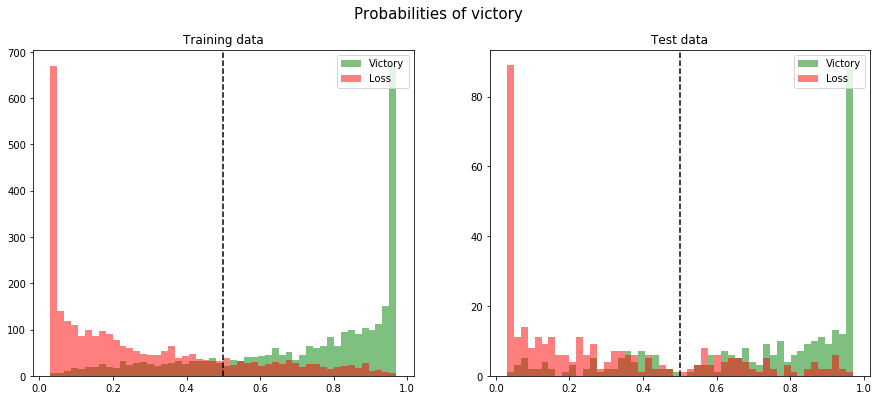

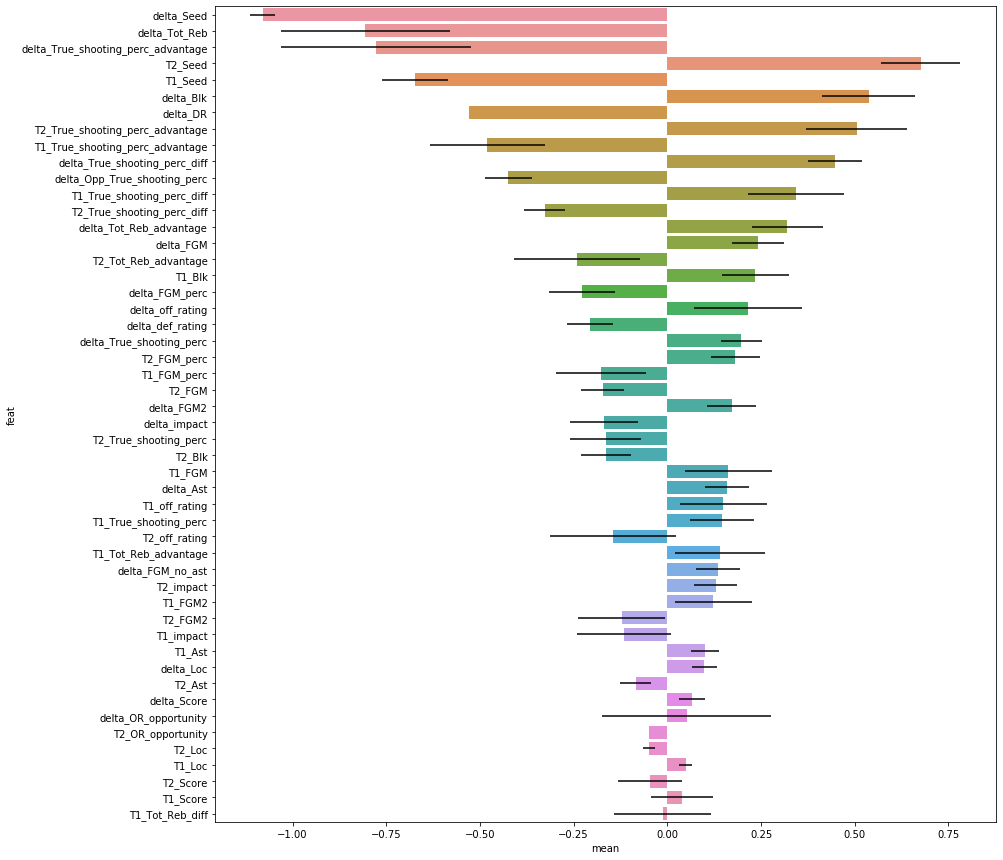

In [8]:
pipe = Pipeline([('scl', df_p.df_scaler()),
                 ('feat_sel', df_p.selector(mode='reg'))] + [('logit', LogisticRegression(solver='lbfgs', max_iter=5000))])

df_train = df[standard + special_selection]#.drop(['T1_Loc', 'T2_Loc', 'delta_Loc'] + to_drop, axis=1)

grid = {'logit__C': np.arange(0.01, 0.5, 0.005), 
        'scl__method': ['standard', 'robust'], 
        'feat_sel__k': [5, 10, 20, 50, 70, 100, 'all']}

fitted_log, oof_pred_log, test_pred_log, imp_coef_log, train_log, y_train_log, test_log, y_test_log = yearly_split(df_train, pipe, kfolds, 'target', predict_proba=True, tune=True, param_grid=grid)

rp.yearly_wrapper(train_log, test_log, y_train_log, y_test_log, oof_pred_log, test_pred_log, points=False)

plt.figure(figsize=(14, 15))
sns.barplot(x="mean", y="feat", 
            data=imp_coef_log['2019'].head(50).reset_index(), 
            xerr=imp_coef_log['2019'].head(50)['std'])
plt.show()

# RandomForest

-10.713526401268117
{'feat_sel__k': 20, 'forest__max_depth': None, 'forest__min_samples_leaf': 1, 'forest__min_samples_split': 32}
-10.184756093464589
{'feat_sel__k': 50, 'forest__max_depth': None, 'forest__min_samples_leaf': 4, 'forest__min_samples_split': 2}
-10.049996507978436
{'feat_sel__k': 20, 'forest__max_depth': None, 'forest__min_samples_leaf': 8, 'forest__min_samples_split': 4}
-10.08770441797039
{'feat_sel__k': 50, 'forest__max_depth': None, 'forest__min_samples_leaf': 1, 'forest__min_samples_split': 16}
-10.510525963571872
{'feat_sel__k': 20, 'forest__max_depth': 10, 'forest__min_samples_leaf': 4, 'forest__min_samples_split': 32}
2015


MAE train: 			 10.6774
MAE test: 			 7.3675
RMSE train: 			 13.2668
RMSE test: 			 9.435
Accuracy train: 		 0.784
Accuracy test: 			 0.8492
AUC ROC train: 			 0.784
AUC ROC test: 			 0.8492
Logloss train: 			 0.4476
Logloss test: 			 0.3785
Unsure train: 			 8.99%
Unsure test: 			 10.32%


________________________________________


2016


MA

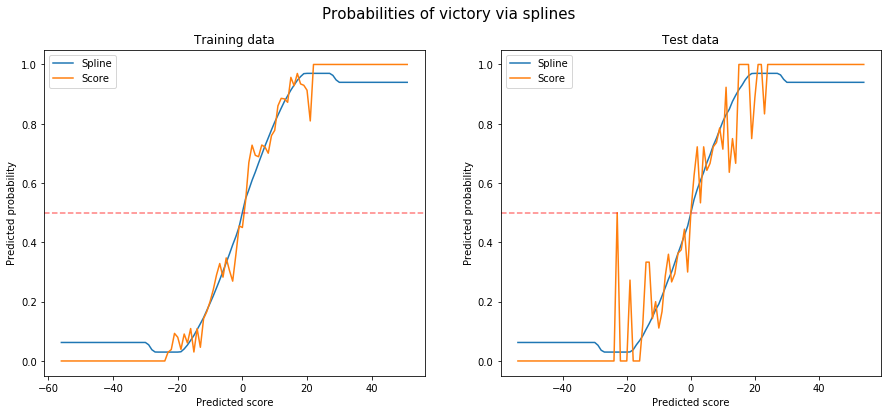

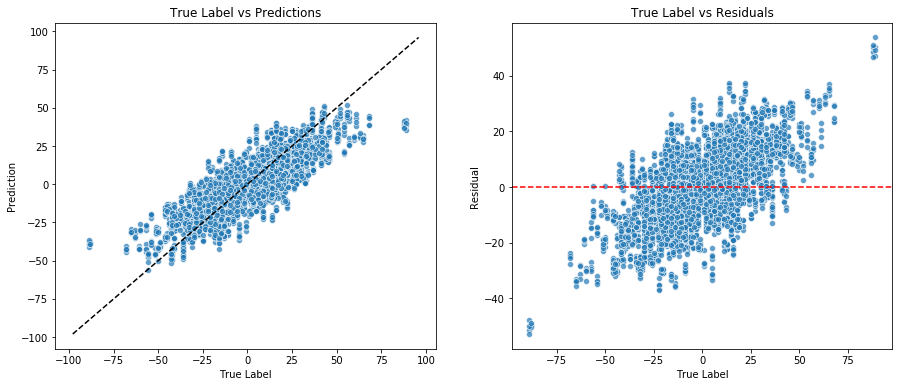

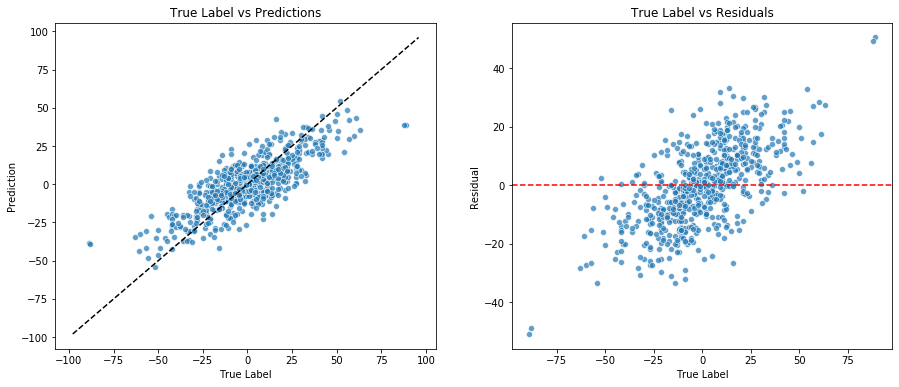

MAE train: 			 10.332
MAE test: 			 10.8402
RMSE train: 			 12.9292
RMSE test: 			 13.6163
Accuracy train: 		 0.7908
Accuracy test: 			 0.7905
AUC ROC train: 			 0.7908
AUC ROC test: 			 0.7905
Logloss train: 			 0.444
Logloss test: 			 0.4728
Unsure train: 			 9.91%
Unsure test: 			 9.84%


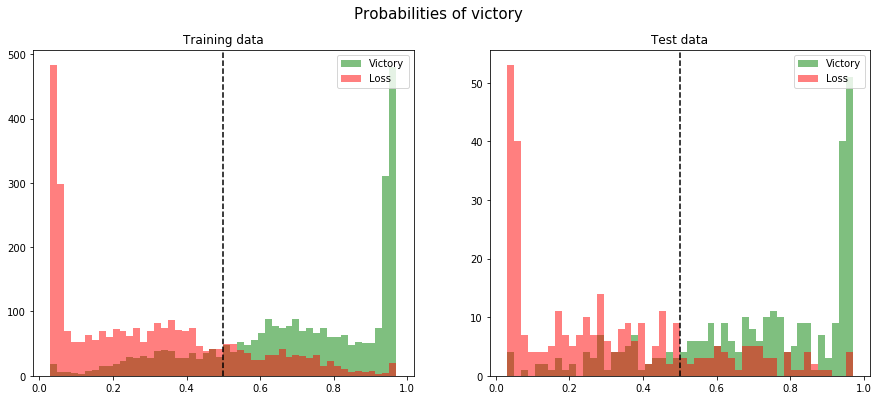

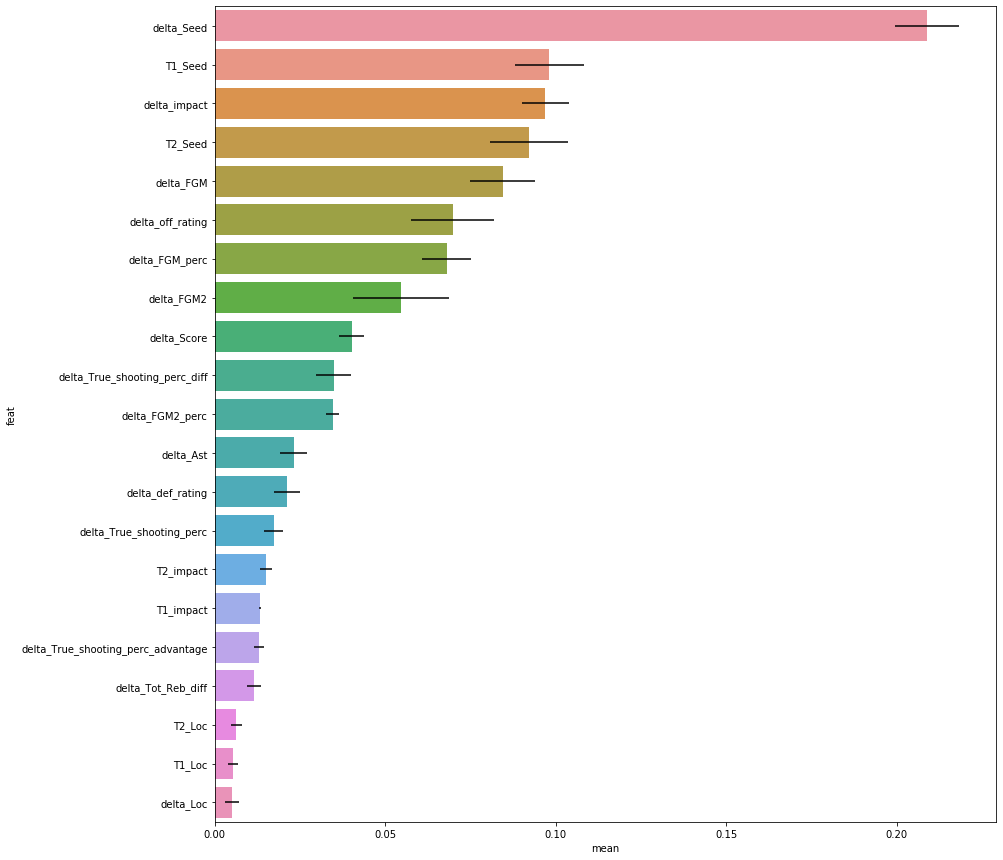

In [9]:
pipe = Pipeline([('scl', df_p.df_scaler()), 
                 ('feat_sel', df_p.selector(mode='reg'))] + [('forest', RandomForestRegressor(n_estimators=500, 
                                                                                max_features='sqrt',
                                                                                n_jobs=5))])

df_train = df[standard + special_selection]

grid = {'forest__max_depth': [3, 10, None], 
        'forest__min_samples_split': [2, 4, 8, 16, 32], 
        'forest__min_samples_leaf': [1, 2, 4, 8, 16], 
        'feat_sel__k': [5, 10 , 20, 50, 100, 'all']}


fitted, oof_pred, test_pred, imp_coef, train, y_train, test, y_test = yearly_split(df_train, pipe, kfolds, 'target_points', tune=True, param_grid=grid)

rp.yearly_wrapper(train, test, y_train, y_test, oof_pred, test_pred)

plt.figure(figsize=(14, 15))
sns.barplot(x="mean", y="feat", 
            data=imp_coef['2019'].head(50).reset_index(), 
            xerr=imp_coef['2019'].head(50)['std'])
plt.show()

-0.44304792214356825
{'feat_sel__k': 5, 'forest__max_depth': 10, 'forest__min_samples_leaf': 16, 'forest__min_samples_split': 2}
-0.4248498077587503
{'feat_sel__k': 10, 'forest__max_depth': None, 'forest__min_samples_leaf': 1, 'forest__min_samples_split': 32}
-0.42573251883870256
{'feat_sel__k': 10, 'forest__max_depth': 10, 'forest__min_samples_leaf': 2, 'forest__min_samples_split': 8}
-0.4387309812606651
{'feat_sel__k': 10, 'forest__max_depth': 10, 'forest__min_samples_leaf': 16, 'forest__min_samples_split': 16}
-0.44492975345195374
{'feat_sel__k': 10, 'forest__max_depth': None, 'forest__min_samples_leaf': 1, 'forest__min_samples_split': 32}
2015


Accuracy train: 		 0.7663
Accuracy test: 			 0.8016
AUC ROC train: 			 0.7663
AUC ROC test: 			 0.8016
Logloss train: 			 0.4495
Logloss test: 			 0.3982
Unsure train: 			 17.7249%
Unsure test: 			 14.2857%


________________________________________


2016


Accuracy train: 		 0.7998
Accuracy test: 			 0.6667
AUC ROC train: 			 0.7998
AUC R

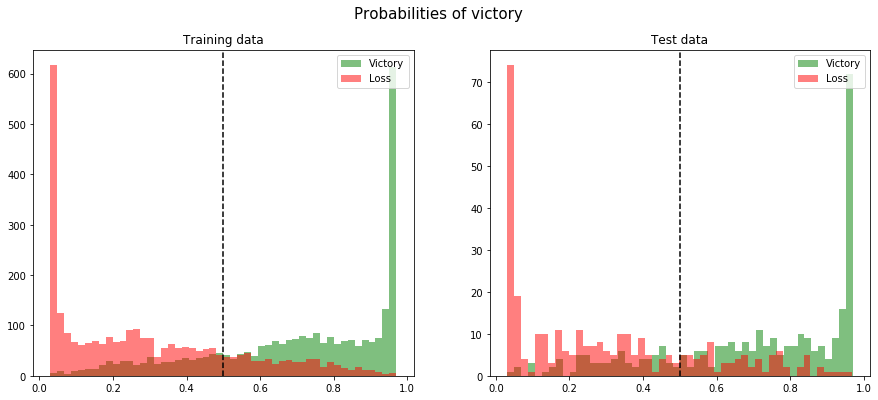

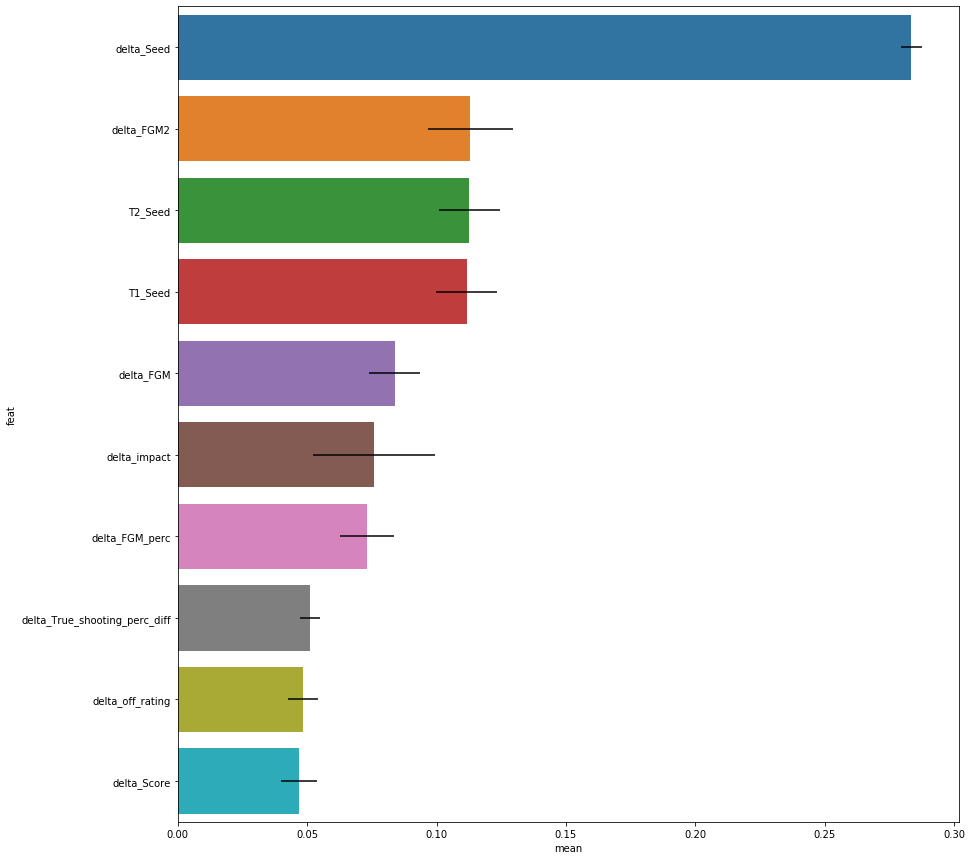

In [10]:
pipe = Pipeline([('scl', df_p.df_scaler()), 
                 ('feat_sel', df_p.selector(mode='clfs'))] + [('forest', RandomForestClassifier(n_estimators=500, 
                                                                                max_features='sqrt',
                                                                                n_jobs=5))])

df_train = df[standard + special_selection]

grid = {'forest__max_depth': [3, 10, None], 
        'forest__min_samples_split': [2, 4, 8, 16, 32], 
        'forest__min_samples_leaf': [1, 2, 4, 8, 16], 
        'feat_sel__k': [5, 10 , 20, 50, 100, 'all']}


fitted, oof_pred, test_pred, imp_coef, train, y_train, test, y_test = yearly_split(df_train, 
                                                                                   pipe, 
                                                                                   kfolds, 
                                                                                   'target', 
                                                                                   tune=True, param_grid=grid, predict_proba=True)

rp.yearly_wrapper(train, test, y_train, y_test, oof_pred, test_pred, points=False)

plt.figure(figsize=(14, 15))
sns.barplot(x="mean", y="feat", 
            data=imp_coef['2019'].head(50).reset_index(), 
            xerr=imp_coef['2019'].head(50)['std'])
plt.show()

# XGBoost

In [11]:
def cauchyobj(preds, dtrain):
    labels = dtrain.get_label()
    c = 5000 
    x =  preds - labels    
    grad = x / (x**2 / c**2 + 1)
    hess = - c**2 *(x**2 - c**2) / (x**2 + c**2)**2
    return grad, hess

In [12]:
X = df[special_selection].values#.drop(to_drop, axis=1).values
y = df['target_points']
dtrain = xgb.DMatrix(X, label = y)

param = {}
param['eval_metric'] =  'mae'
param['booster'] = 'gbtree'
param['eta'] = 0.05 #change to ~0.02 for final run
param['subsample'] = 0.35
param['colsample_bytree'] = 0.7
param['num_parallel_tree'] = 10 #recommend 10
param['min_child_weight'] = 40
param['gamma'] = 10
param['max_depth'] =  3
param['silent'] = 1

xgb_cv = []
repeat_cv = 5

for i in range(repeat_cv): 
    print(f"Fold repeater {i}")
    xgb_cv.append(
        xgb.cv(
          params = param,
          dtrain = dtrain,
          obj = cauchyobj,
          num_boost_round = 3000,
          folds = KFold(n_splits = 5, shuffle = True, random_state = i),
          early_stopping_rounds = 50,
          verbose_eval = 50
        )
    )
    
iteration_counts = [np.argmin(x['test-mae-mean'].values) for x in xgb_cv]
val_mae = [np.min(x['test-mae-mean'].values) for x in xgb_cv]

print(iteration_counts, val_mae)

oof_preds = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    preds = y.copy()
    kfold = KFold(n_splits = 5, shuffle = True, random_state = i)    
    for train_index, val_index in kfold.split(X, y):
        dtrain_i = xgb.DMatrix(X[train_index], label = preds[train_index])
        dval_i = xgb.DMatrix(X[val_index], label = preds[val_index])  
        model = xgb.train(
              params = param,
              dtrain = dtrain_i,
              num_boost_round = iteration_counts[i],
              verbose_eval = 50
        )
        preds[val_index] = model.predict(dval_i)
    oof_preds.append(np.clip(preds,-30,30))


spline_model = []
val_cv = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i], np.where(y > 0, 1, 0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y > 0, 1, 0),spline_fit)}")
    val_cv.append(pd.DataFrame({"y":np.where(y > 0, 1, 0), 
                                "pred":spline_fit, 
                                "season":df.Season}))
    
val_cv = pd.concat(val_cv)
val_cv.groupby('season').apply(lambda x: log_loss(x.y, x.pred))

Fold repeater 0
[0]	train-mae:16.61779+0.15516	test-mae:16.63764+0.66470
[50]	train-mae:9.84167+0.10989	test-mae:10.62514+0.44854
[100]	train-mae:8.95797+0.11065	test-mae:10.35002+0.41615
[150]	train-mae:8.38903+0.11652	test-mae:10.28582+0.43646
[200]	train-mae:7.91591+0.11942	test-mae:10.30428+0.45506
Fold repeater 1
[0]	train-mae:16.61976+0.20731	test-mae:16.64344+0.86929
[50]	train-mae:9.83143+0.08450	test-mae:10.63348+0.50087
[100]	train-mae:8.93253+0.05767	test-mae:10.37908+0.40637
[150]	train-mae:8.35683+0.05733	test-mae:10.35323+0.37260
Fold repeater 2
[0]	train-mae:16.61819+0.16897	test-mae:16.63784+0.68618
[50]	train-mae:9.84095+0.12570	test-mae:10.66025+0.59765
[100]	train-mae:8.94040+0.13566	test-mae:10.39559+0.60624
[150]	train-mae:8.36524+0.13142	test-mae:10.35502+0.60171
[200]	train-mae:7.89150+0.12697	test-mae:10.35660+0.59453
Fold repeater 3
[0]	train-mae:16.62364+0.28755	test-mae:16.62929+1.20775
[50]	train-mae:9.84401+0.10319	test-mae:10.57484+0.56251
[100]	train-mae:

season
2010    0.408894
2011    0.373801
2012    0.392191
2013    0.446989
2014    0.405773
2015    0.374082
2016    0.557936
2017    0.515633
2018    0.473205
2019    0.373950
dtype: float64

In [10]:
tot

['T1_Score',
 'T1_FGM',
 'T1_FGA',
 'T1_FGM3',
 'T1_FGA3',
 'T1_FTM',
 'T1_FTA',
 'T1_OR',
 'T1_DR',
 'T1_Ast',
 'T1_TO',
 'T1_Stl',
 'T1_Blk',
 'T1_PF',
 'T1_FGM2',
 'T1_FGA2',
 'T1_Tot_Reb',
 'T1_FGM_no_ast',
 'T1_possessions',
 'T1_off_rating',
 'T1_shtg_opportunity',
 'T1_TO_perposs',
 'T1_def_rating',
 'T1_opp_shtg_opportunity',
 'T1_opp_possessions',
 'T1_opp_score',
 'T1_opp_FTA',
 'T1_opp_FGA',
 'T1_impact',
 'T1_DR_opportunity',
 'T1_OR_opportunity',
 'T1_Score_diff',
 'T1_Score_advantage',
 'T1_FGM_diff',
 'T1_FGM_advantage',
 'T1_FGA_diff',
 'T1_FGA_advantage',
 'T1_FGM3_diff',
 'T1_FGM3_advantage',
 'T1_FGA3_diff',
 'T1_FGA3_advantage',
 'T1_FTM_diff',
 'T1_FTM_advantage',
 'T1_FTA_diff',
 'T1_FTA_advantage',
 'T1_OR_diff',
 'T1_OR_advantage',
 'T1_DR_diff',
 'T1_DR_advantage',
 'T1_Ast_diff',
 'T1_Ast_advantage',
 'T1_TO_diff',
 'T1_TO_advantage',
 'T1_Stl_diff',
 'T1_Stl_advantage',
 'T1_Blk_diff',
 'T1_Blk_advantage',
 'T1_PF_diff',
 'T1_PF_advantage',
 'T1_FGM2_diff',
 

2015


MAE train: 			 10.8255
MAE test: 			 8.6237
RMSE train: 			 13.37
RMSE test: 			 11.2259
Accuracy train: 		 0.7769
Accuracy test: 			 0.8413
AUC ROC train: 			 0.7769
AUC ROC test: 			 0.8413
Logloss train: 			 0.4573
Logloss test: 			 0.399
Unsure train: 			 10.93%
Unsure test: 			 13.49%


________________________________________


2016


MAE train: 			 10.5801
MAE test: 			 12.3255
RMSE train: 			 13.1439
RMSE test: 			 14.8473
Accuracy train: 		 0.7892
Accuracy test: 			 0.6667
AUC ROC train: 			 0.7892
AUC ROC test: 			 0.6667
Logloss train: 			 0.4352
Logloss test: 			 0.5754
Unsure train: 			 10.32%
Unsure test: 			 6.35%


________________________________________


2017


MAE train: 			 10.4036
MAE test: 			 12.313
RMSE train: 			 12.9071
RMSE test: 			 15.2666
Accuracy train: 		 0.7795
Accuracy test: 			 0.8175
AUC ROC train: 			 0.7795
AUC ROC test: 			 0.8175
Logloss train: 			 0.4349
Logloss test: 			 0.4765
Unsure train: 			 13.76%
Unsure test: 			 9.52%


_________

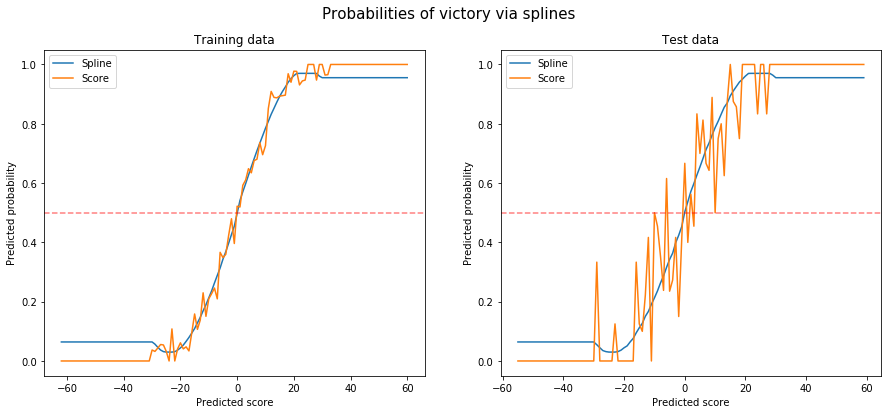

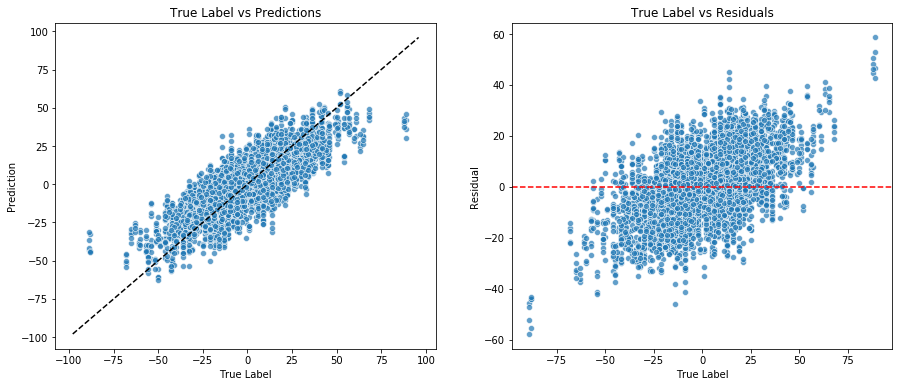

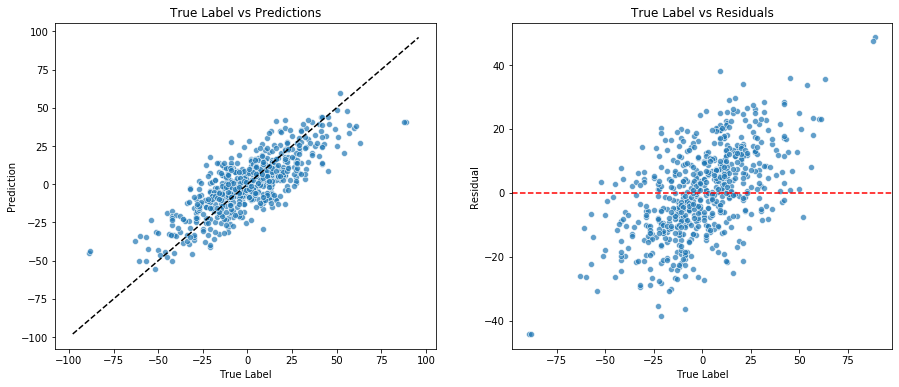

MAE train: 			 10.6026
MAE test: 			 11.1182
RMSE train: 			 13.2223
RMSE test: 			 13.9057
Accuracy train: 		 0.7783
Accuracy test: 			 0.7714
AUC ROC train: 			 0.7783
AUC ROC test: 			 0.7714
Logloss train: 			 0.447
Logloss test: 			 0.4702
Unsure train: 			 12.01%
Unsure test: 			 8.89%


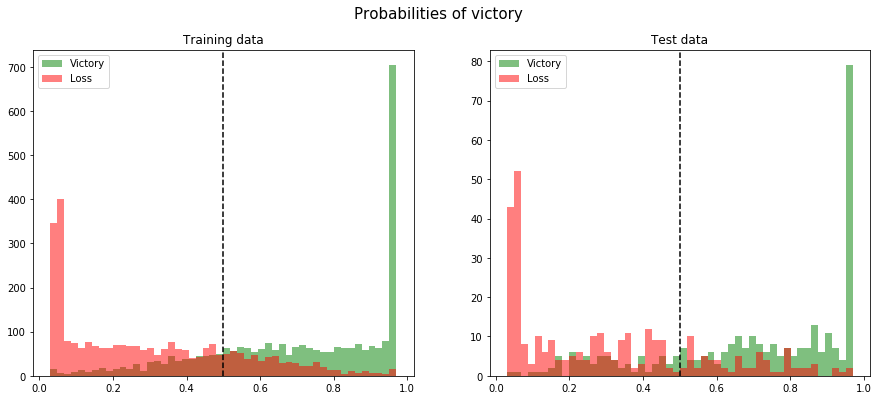

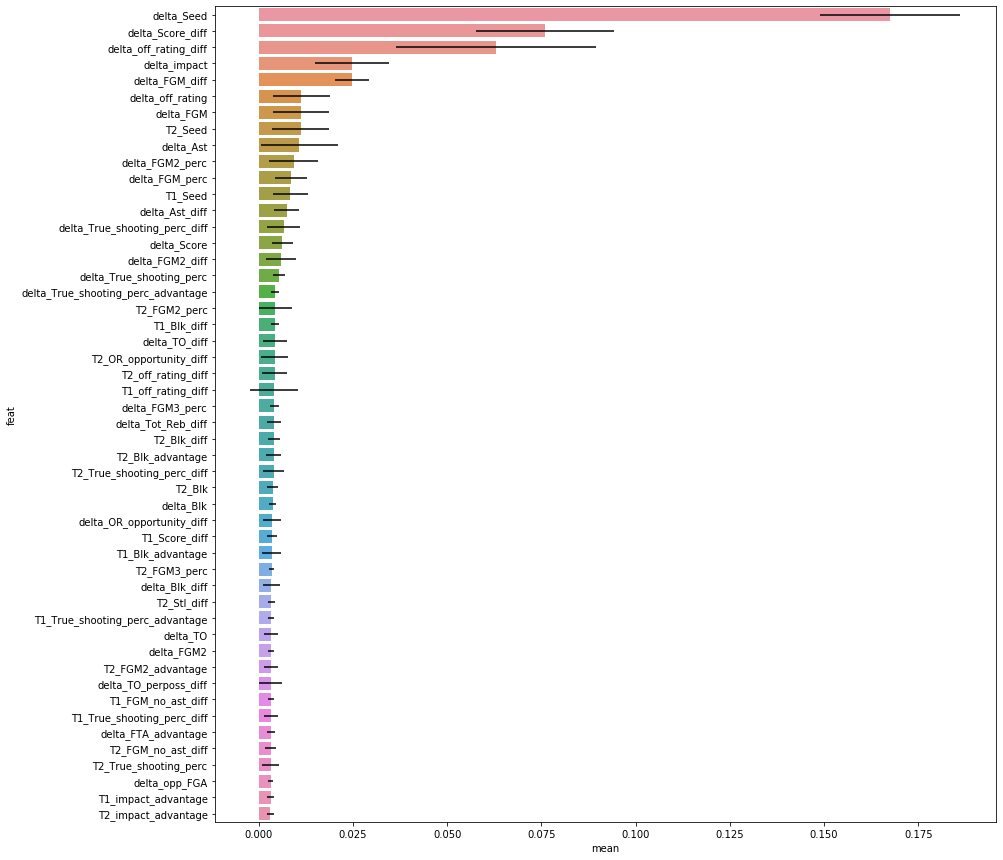

In [10]:
pipe = Pipeline([('scl', df_p.df_scaler())] + [('xgb', XGBRegressor(learning_rate=0.1, 
                                                                    n_estimators=150,
                                                                    subsample=0.8,
                                                                    objective='reg:squarederror', 
                                                                    n_jobs=5))])

df_train = df[standard + tot]

grid = {'xgb__n_estimators': [20, 50, 100, 500]}

fitted, oof_pred, test_pred, imp_coef, train, y_train, test, y_test = yearly_split(df_train, pipe, kfolds, 'target_points', tune=False, param_grid=grid)

rp.yearly_wrapper(train, test, y_train, y_test, oof_pred, test_pred)

plt.figure(figsize=(14, 15))
sns.barplot(x="mean", y="feat", 
            data=imp_coef['2019'].head(50).reset_index(), 
            xerr=imp_coef['2019'].head(50)['std'])
plt.show()

________________________________________
lasso
2015


MAE train: 			 9.8941
MAE test: 			 8.2248
RMSE train: 			 12.5172
RMSE test: 			 10.8043
Accuracy train: 		 0.7937
Accuracy test: 			 0.8254
AUC ROC train: 		 0.7937
AUC ROC test: 			 0.8254
Logloss train: 			 0.4276
Logloss test: 			 0.3951
Unsure train: 			 8.91%
Unsure test: 			 11.11%


________________________________________


2016


MAE train: 			 9.6158
MAE test: 			 10.9239
RMSE train: 			 12.2197
RMSE test: 			 13.6105
Accuracy train: 		 0.8104
Accuracy test: 			 0.6984
AUC ROC train: 		 0.8104
AUC ROC test: 			 0.6984
Logloss train: 			 0.4149
Logloss test: 			 0.5226
Unsure train: 			 7.94%
Unsure test: 			 9.52%


________________________________________


2017


MAE train: 			 9.5124
MAE test: 			 11.8448
RMSE train: 			 12.064
RMSE test: 			 14.5808
Accuracy train: 		 0.7945
Accuracy test: 			 0.8413
AUC ROC train: 		 0.7945
AUC ROC test: 			 0.8413
Logloss train: 			 0.4192
Logloss test: 			 0.474
Unsure train: 			 

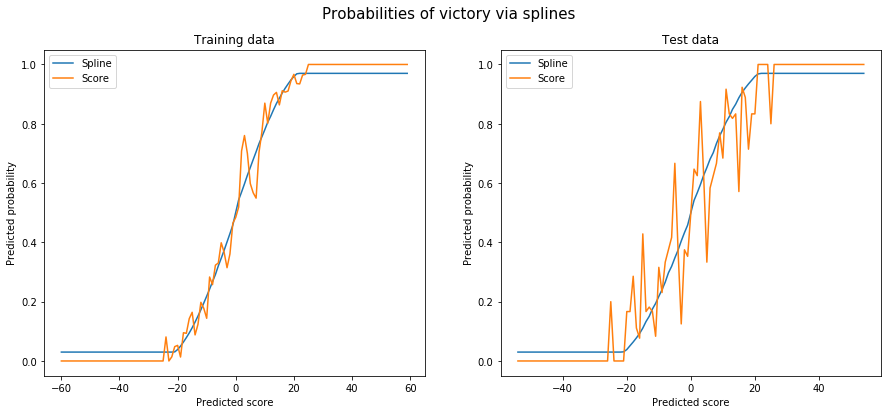

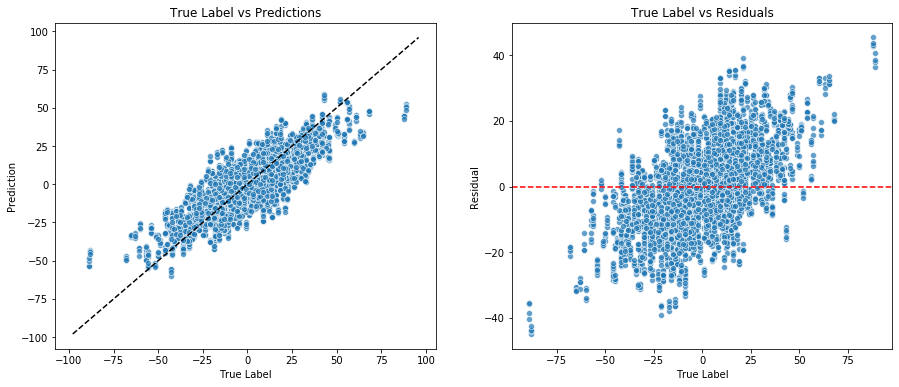

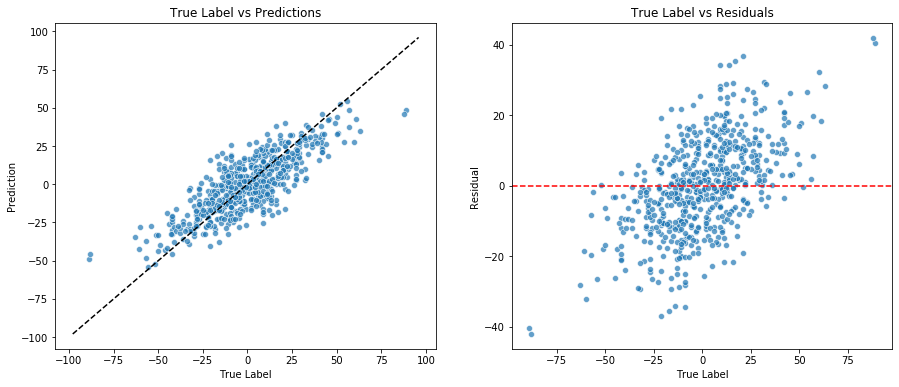

MAE train: 			 9.6747
MAE test: 			 10.3238
RMSE train: 			 12.2503
RMSE test: 			 13.1946
Accuracy train: 		 0.8
Accuracy test: 			 0.7841
AUC ROC train: 		 0.8
AUC ROC test: 			 0.7841
Logloss train: 			 0.4205
Logloss test: 			 0.4522
Unsure train: 			 9.1%
Unsure test: 			 9.52%
________________________________________
________________________________________
________________________________________
ridge
2015


MAE train: 			 10.1675
MAE test: 			 8.2395
RMSE train: 			 12.8492
RMSE test: 			 10.9544
Accuracy train: 		 0.7884
Accuracy test: 			 0.8095
AUC ROC train: 		 0.7884
AUC ROC test: 			 0.8095
Logloss train: 			 0.4395
Logloss test: 			 0.3836
Unsure train: 			 8.82%
Unsure test: 			 11.11%


________________________________________


2016


MAE train: 			 9.8698
MAE test: 			 11.0617
RMSE train: 			 12.5686
RMSE test: 			 13.8519
Accuracy train: 		 0.7981
Accuracy test: 			 0.7302
AUC ROC train: 		 0.7981
AUC ROC test: 			 0.7302
Logloss train: 			 0.4287
Logloss test: 			

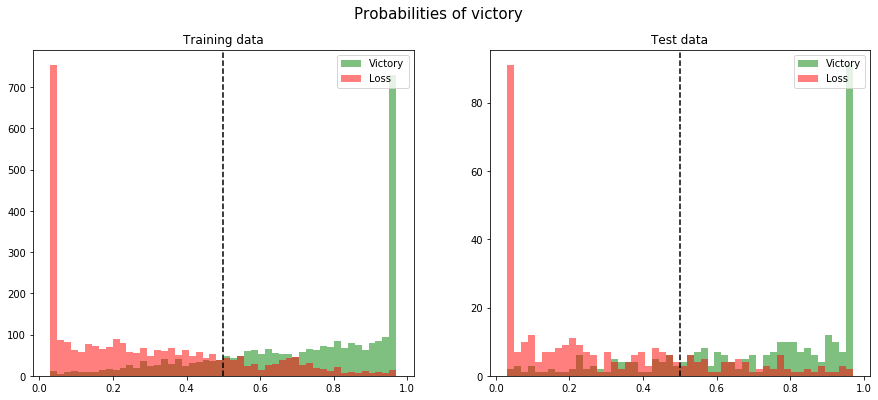

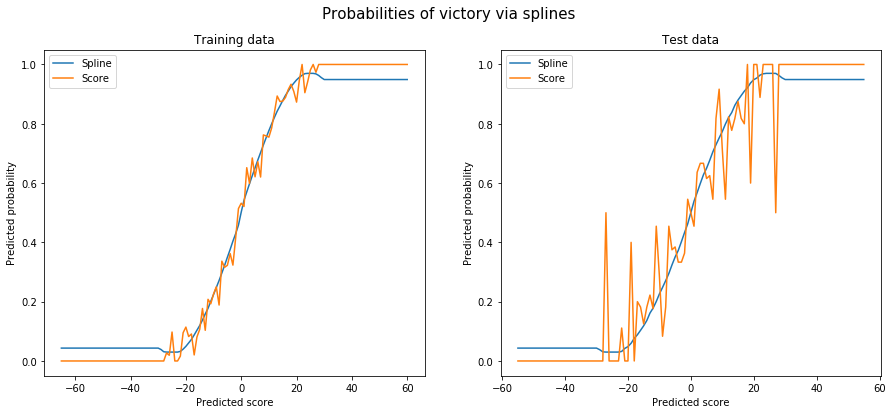

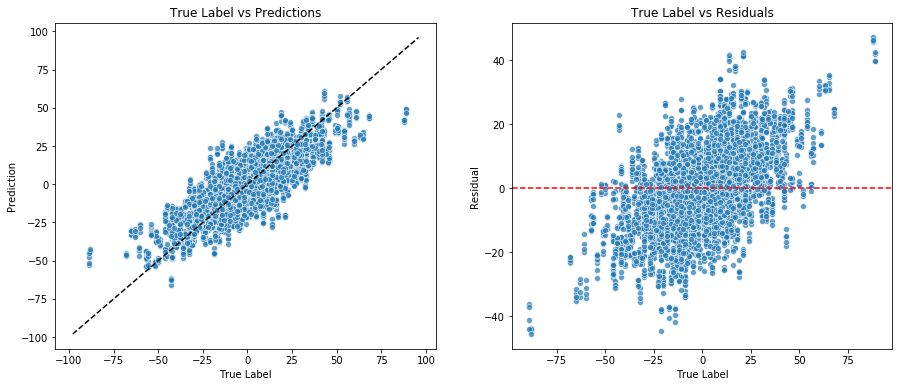

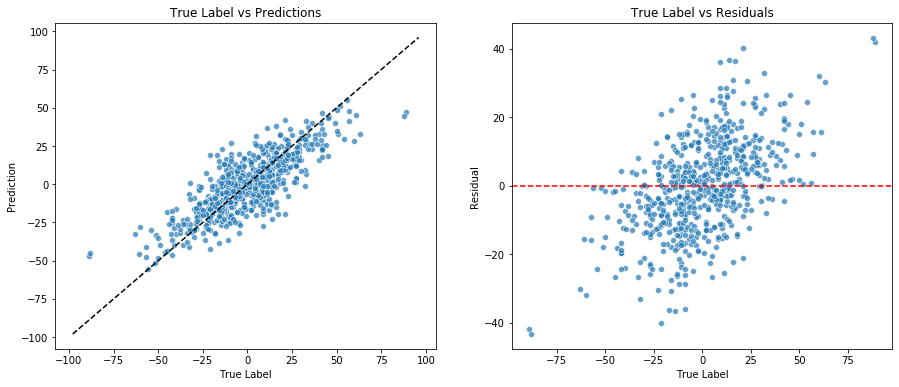

MAE train: 			 9.9108
MAE test: 			 10.4702
RMSE train: 			 12.5631
RMSE test: 			 13.5099
Accuracy train: 		 0.7933
Accuracy test: 			 0.781
AUC ROC train: 		 0.7933
AUC ROC test: 			 0.781
Logloss train: 			 0.4314
Logloss test: 			 0.4604
Unsure train: 			 8.8%
Unsure test: 			 9.84%
________________________________________
________________________________________
________________________________________
forest
2015


MAE train: 			 10.7457
MAE test: 			 7.5114
RMSE train: 			 13.2587
RMSE test: 			 10.0291
Accuracy train: 		 0.7734
Accuracy test: 			 0.8254
AUC ROC train: 		 0.7734
AUC ROC test: 			 0.8254
Logloss train: 			 0.4499
Logloss test: 			 0.3814
Unsure train: 			 9.26%
Unsure test: 			 5.56%


________________________________________


2016


MAE train: 			 10.2739
MAE test: 			 11.6742
RMSE train: 			 12.8122
RMSE test: 			 14.3008
Accuracy train: 		 0.7963
Accuracy test: 			 0.6984
AUC ROC train: 		 0.7963
AUC ROC test: 			 0.6984
Logloss train: 			 0.4332
Logloss test

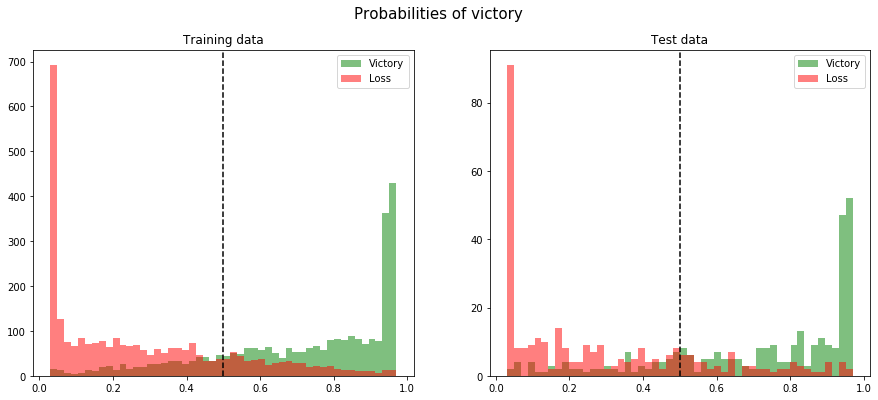

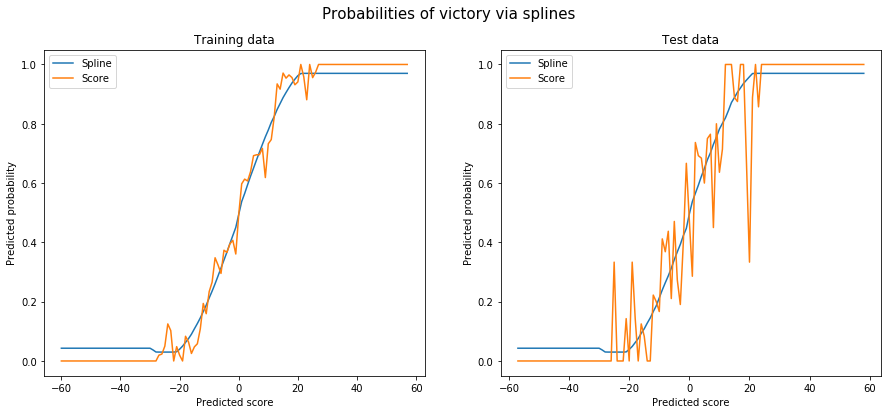

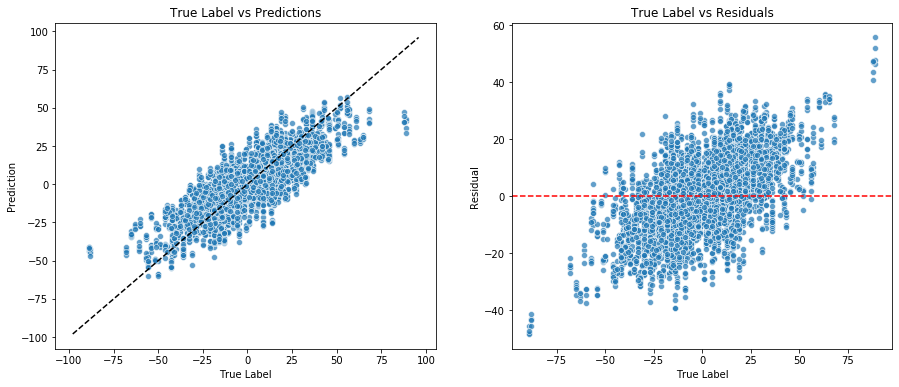

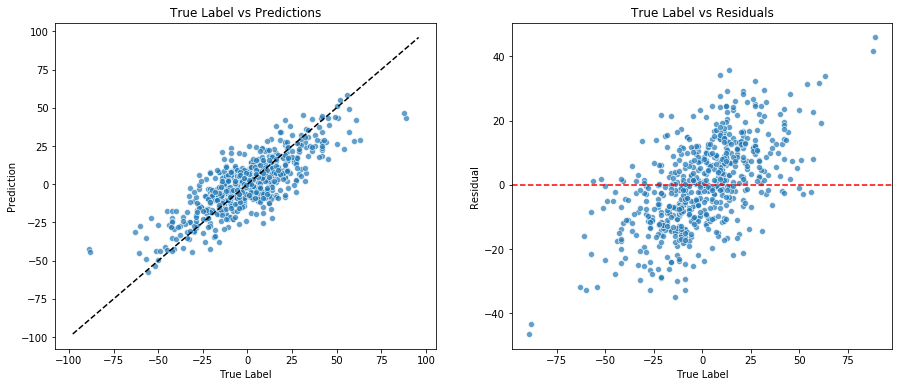

MAE train: 			 10.4195
MAE test: 			 10.5468
RMSE train: 			 12.9387
RMSE test: 			 13.3631
Accuracy train: 		 0.7836
Accuracy test: 			 0.7714
AUC ROC train: 		 0.7836
AUC ROC test: 			 0.7714
Logloss train: 			 0.4422
Logloss test: 			 0.465
Unsure train: 			 10.04%
Unsure test: 			 7.14%
________________________________________
________________________________________
________________________________________
xtree
2015


MAE train: 			 10.4739
MAE test: 			 7.8363
RMSE train: 			 12.9666
RMSE test: 			 10.0535
Accuracy train: 		 0.7945
Accuracy test: 			 0.8333
AUC ROC train: 		 0.7945
AUC ROC test: 			 0.8333
Logloss train: 			 0.4406
Logloss test: 			 0.3804
Unsure train: 			 10.05%
Unsure test: 			 8.73%


________________________________________


2016


MAE train: 			 9.9994
MAE test: 			 11.6316
RMSE train: 			 12.5008
RMSE test: 			 14.2725
Accuracy train: 		 0.8104
Accuracy test: 			 0.7063
AUC ROC train: 		 0.8104
AUC ROC test: 			 0.7063
Logloss train: 			 0.4247
Logloss t

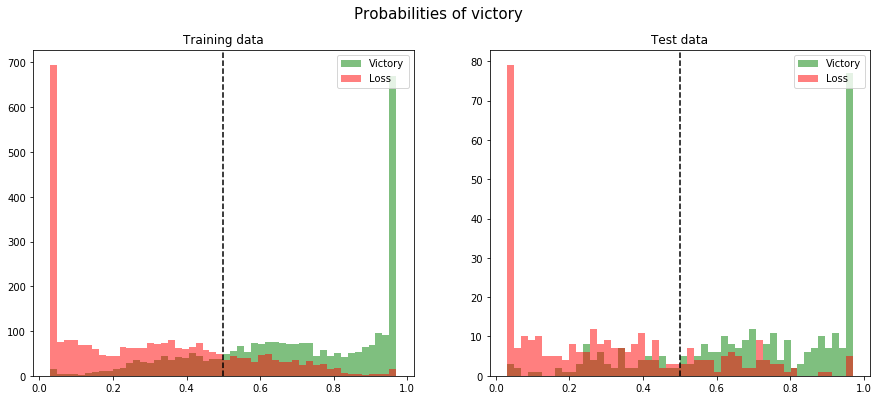

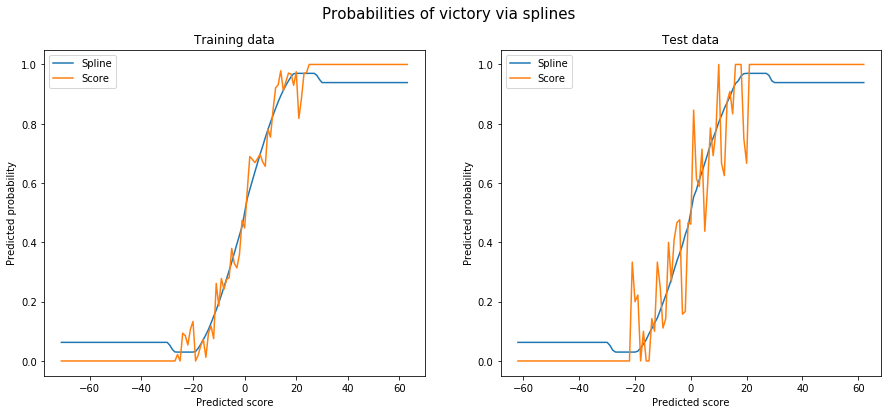

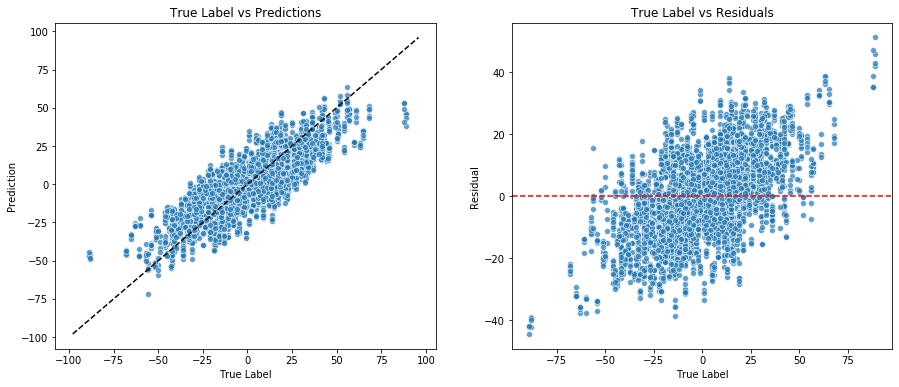

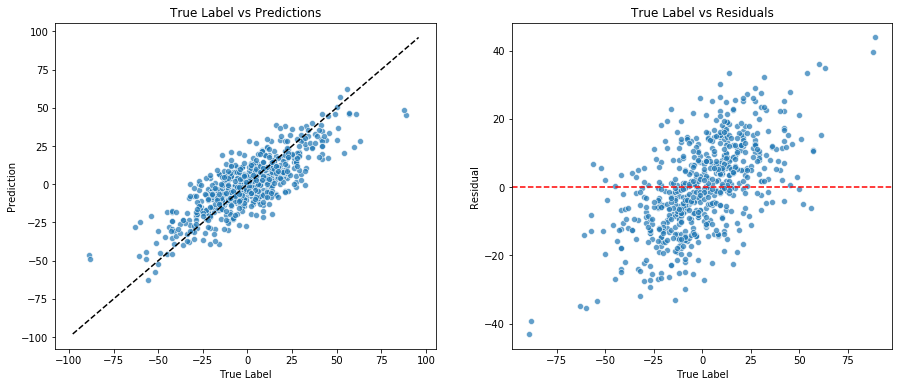

MAE train: 			 10.2106
MAE test: 			 10.552
RMSE train: 			 12.685
RMSE test: 			 13.2055
Accuracy train: 		 0.794
Accuracy test: 			 0.7825
AUC ROC train: 		 0.794
AUC ROC test: 			 0.7825
Logloss train: 			 0.4366
Logloss test: 			 0.4649
Unsure train: 			 10.92%
Unsure test: 			 8.57%
________________________________________
________________________________________
________________________________________
xgb
2015


MAE train: 			 11.3869
MAE test: 			 9.2562
RMSE train: 			 14.1461
RMSE test: 			 12.1501
Accuracy train: 		 0.7628
Accuracy test: 			 0.8016
AUC ROC train: 		 0.7628
AUC ROC test: 			 0.8016
Logloss train: 			 0.4729
Logloss test: 			 0.4127
Unsure train: 			 10.76%
Unsure test: 			 9.52%


________________________________________


2016


MAE train: 			 10.6538
MAE test: 			 14.0937
RMSE train: 			 13.3698
RMSE test: 			 16.8583
Accuracy train: 		 0.7654
Accuracy test: 			 0.6508
AUC ROC train: 		 0.7654
AUC ROC test: 			 0.6508
Logloss train: 			 0.4541
Logloss test:

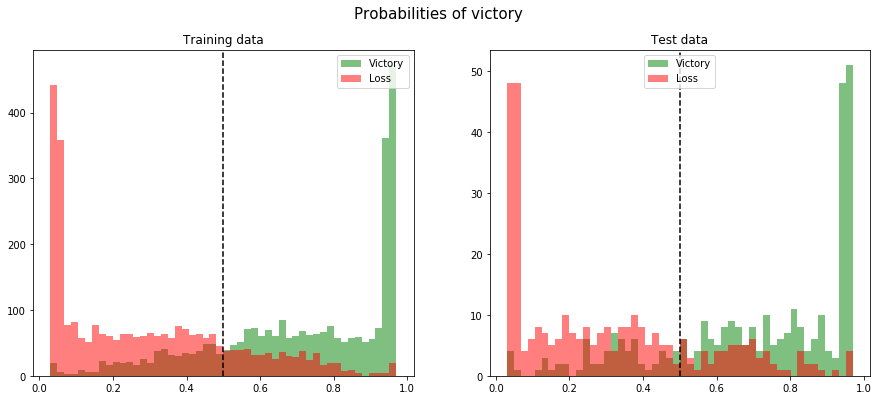

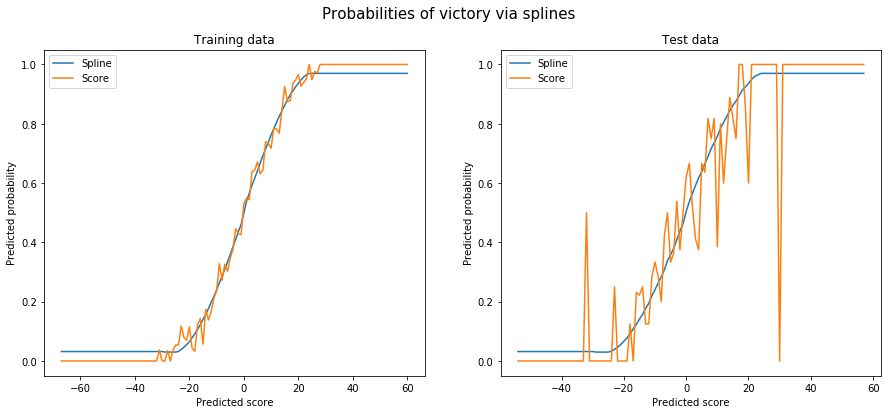

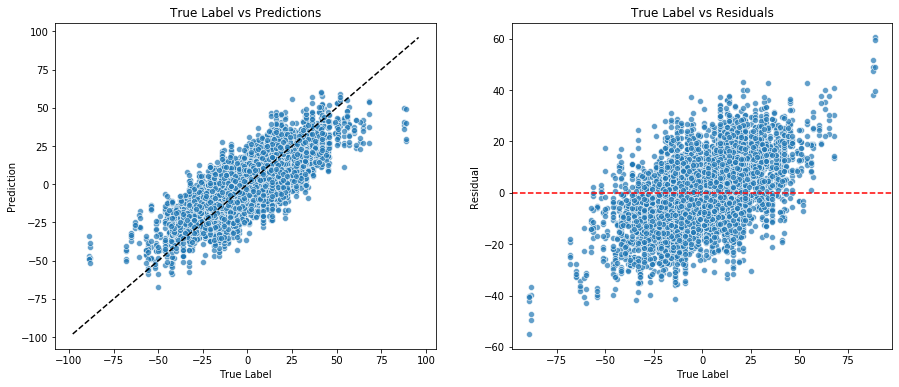

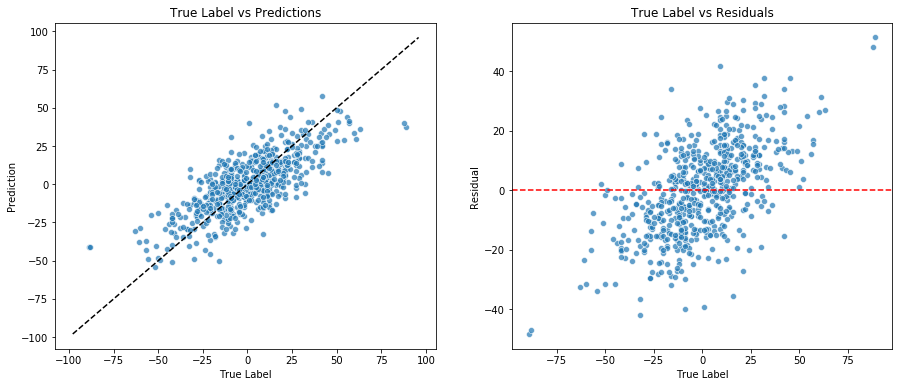

MAE train: 			 10.9992
MAE test: 			 12.0035
RMSE train: 			 13.738
RMSE test: 			 14.9703
Accuracy train: 		 0.7647
Accuracy test: 			 0.7492
AUC ROC train: 		 0.7647
AUC ROC test: 			 0.7492
Logloss train: 			 0.462
Logloss test: 			 0.4758
Unsure train: 			 10.86%
Unsure test: 			 9.37%
________________________________________
________________________________________


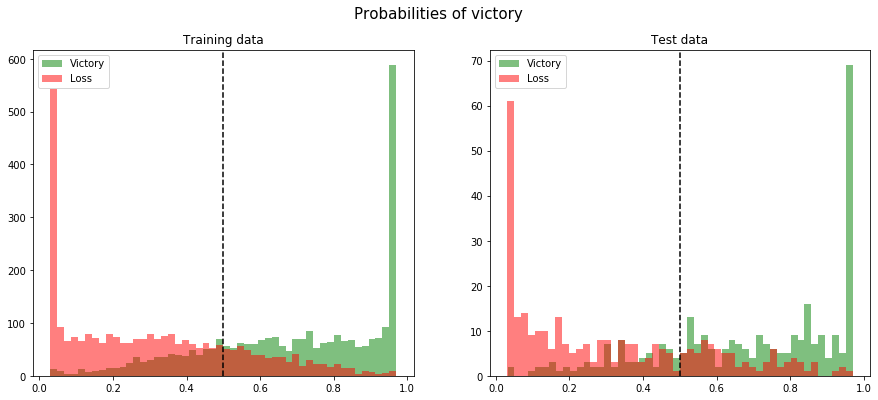

In [3]:
standard = ['Season', 'target', 'target_points', 'ID']

l2w = [col for col in df if 'L2W' in col and col not in standard]
tot = [col for col in df if 'L2W' not in col and col not in standard]
l2w_deltas = [col for col in df if 'L2W' in col and col not in standard and 'delta' in col]
tot_deltas = [col for col in df if 'L2W' not in col and col not in standard and 'delta' in col]

models = [('lasso', Lasso(alpha=0.1, max_iter=2000)), 
          ('ridge', Ridge()), 
          ('forest', RandomForestRegressor(n_estimators=500, n_jobs=5)), 
          ('xtree', ExtraTreesRegressor(n_estimators=500, n_jobs=5)), 
          ('xgb', XGBRegressor(n_estimators=100, objective='reg:squarederror', n_jobs=5))]

for model in models:
    print('_'*40)
    print(model[0])
    df_train = df[standard + tot]

    pipe = Pipeline([('scl', df_p.df_scaler())] + [model])

    fitted, oof_pred, test_pred, imp_coef, train, y_train, test, y_test = yearly_split(df_train, pipe, kfolds, 'target_points')

    rp.yearly_wrapper(train, test, y_train, y_test, oof_pred, test_pred)
    print('_'*40)
    print('_'*40)

In [3]:
standard = ['Season', 'target', 'target_points', 'ID']

l2w = [col for col in df if 'L2W' in col and col not in standard]
tot = [col for col in df if 'L2W' not in col and col not in standard]
l2w_deltas = [col for col in df if 'L2W' in col and col not in standard and 'delta' in col]
tot_deltas = [col for col in df if 'L2W' not in col and col not in standard and 'delta' in col]

feat_dict = {'l2w': l2w, 'tot': tot, 'l2w_delta': l2w_deltas, 'tot_delta': tot_deltas}

models = [('lasso', Lasso(alpha=0.1)), 
          ('ridge', Ridge()), 
          ('forest', RandomForestRegressor(n_estimators=200, n_jobs=5)), ('xtree', ExtraTreesRegressor(n_estimators=200, n_jobs=5)), 
          ('xgb', XGBRegressor(n_estimators=100, objective='reg:squarederror'))]

for model in models:
    print('_'*40)
    print(model[0])
    for feats in feat_dict.keys():
        print(f'\t {feats}')
        print('\t'+'-'*30)
        df_train = df[standard + feat_dict[feats]]
        
        pipe = Pipeline([('scl', df_p.df_scaler())] + [model])
        
        fitted, oof_pred, test_pred, imp_coef, train, y_train, test, y_test = random_split(df_train, pipe, kfolds, 'target_points')
        
        rp.report_points(train, test, y_train, y_test, oof_pred, test_pred, plot=False)
        print('\t'+'-'*30)
    print('_'*40)

________________________________________
lasso
	 l2w
	------------------------------
MAE train: 			 13.8105
MAE test: 			 15.1821
RMSE train: 			 17.4357
RMSE test: 			 19.8434
Accuracy train: 		 0.6964
Accuracy test: 			 0.623
Logloss train: 			 0.5817
Logloss test: 			 0.619
Unsure train: 			 6.85%
Unsure test: 			 9.52%
	------------------------------
	 tot
	------------------------------
MAE train: 			 9.6414
MAE test: 			 10.6548
RMSE train: 			 12.233
RMSE test: 			 13.3918
Accuracy train: 		 0.8075
Accuracy test: 			 0.7579
Logloss train: 			 0.4163
Logloss test: 			 0.4818
Unsure train: 			 5.65%
Unsure test: 			 7.54%
	------------------------------
	 l2w_delta
	------------------------------
MAE train: 			 13.5166
MAE test: 			 14.9475
RMSE train: 			 17.1183
RMSE test: 			 19.4619
Accuracy train: 		 0.7004
Accuracy test: 			 0.6508
Logloss train: 			 0.5715
Logloss test: 			 0.6073
Unsure train: 			 6.45%
Unsure test: 			 9.13%
	------------------------------
	 tot_delta
	--

/home/lucabasa/Git/kaggle_competitions/marc_madness/ncaa/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/lucabasa/Git/kaggle_competitions/marc_madness/ncaa/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


MAE train: 			 14.1688
MAE test: 			 15.4772
RMSE train: 			 17.6343
RMSE test: 			 20.0028
Accuracy train: 		 0.6577
Accuracy test: 			 0.6508
Logloss train: 			 0.6035
Logloss test: 			 0.6367
Unsure train: 			 8.53%
Unsure test: 			 11.9%
	------------------------------
	 tot
	------------------------------


/home/lucabasa/Git/kaggle_competitions/marc_madness/ncaa/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/lucabasa/Git/kaggle_competitions/marc_madness/ncaa/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


MAE train: 			 10.1703
MAE test: 			 11.4798
RMSE train: 			 12.7326
RMSE test: 			 14.1799
Accuracy train: 		 0.7917
Accuracy test: 			 0.746
Logloss train: 			 0.434
Logloss test: 			 0.5039
Unsure train: 			 4.96%
Unsure test: 			 7.14%
	------------------------------
	 l2w_delta
	------------------------------


/home/lucabasa/Git/kaggle_competitions/marc_madness/ncaa/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/lucabasa/Git/kaggle_competitions/marc_madness/ncaa/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


MAE train: 			 14.6129
MAE test: 			 16.6685
RMSE train: 			 18.1975
RMSE test: 			 21.386
Accuracy train: 		 0.6716
Accuracy test: 			 0.6111
Logloss train: 			 0.6203
Logloss test: 			 0.6616
Unsure train: 			 7.14%
Unsure test: 			 11.11%
	------------------------------
	 tot_delta
	------------------------------


/home/lucabasa/Git/kaggle_competitions/marc_madness/ncaa/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/lucabasa/Git/kaggle_competitions/marc_madness/ncaa/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


MAE train: 			 10.0249
MAE test: 			 11.3675
RMSE train: 			 12.4968
RMSE test: 			 14.0747
Accuracy train: 		 0.7976
Accuracy test: 			 0.7421
Logloss train: 			 0.4334
Logloss test: 			 0.5042
Unsure train: 			 4.96%
Unsure test: 			 5.56%
	------------------------------
________________________________________


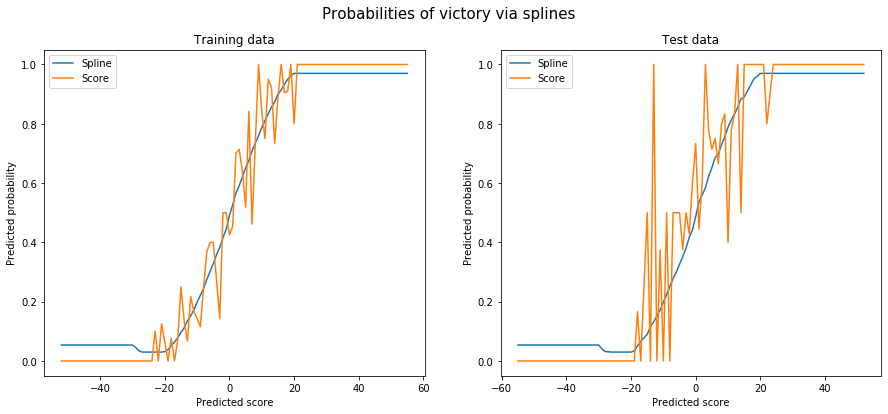

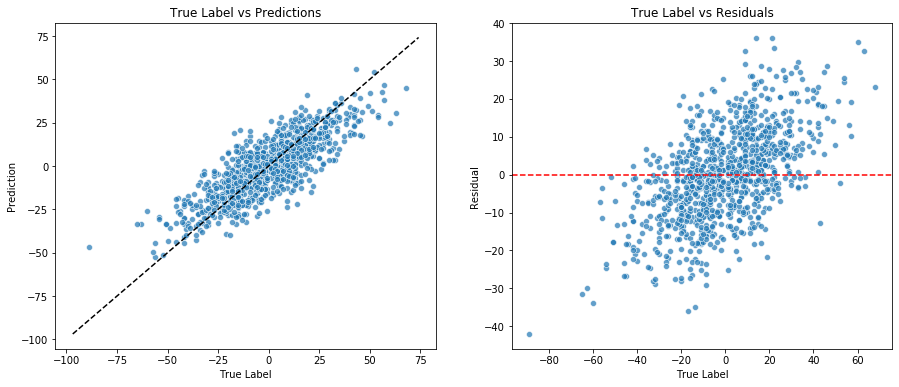

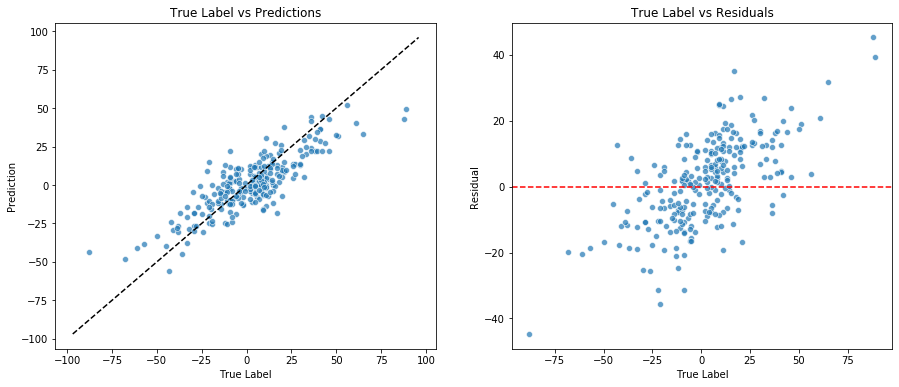

MAE train: 			 9.4494
MAE test: 			 10.493
RMSE train: 			 12.02
RMSE test: 			 13.1618
Accuracy train: 		 0.8056
Accuracy test: 			 0.7619
Logloss train: 			 0.4094
Logloss test: 			 0.4696
Unsure train: 			 4.66%
Unsure test: 			 5.95%


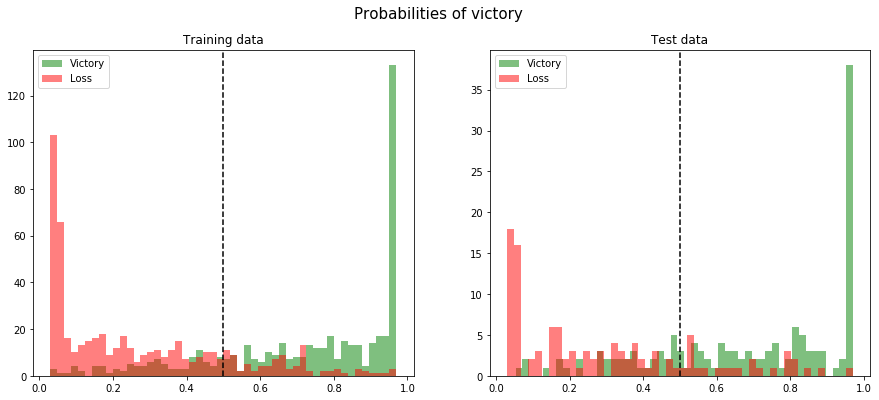

In [5]:
pipe = Pipeline([('scl', df_p.df_scaler()), ('lasso', Lasso(alpha=0.1))])

fitted, oof_pred, test_pred, imp_coef, train, y_train, test, y_test = random_split(df_train, pipe, kfolds, 'target_points')

rp.report_points(train, test, y_train, y_test, oof_pred, test_pred)